In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### variable

- PatientId - 환자를 식별할수 식별자
- AppointmentID - 예약의 식별자
- Gender = 성별 (여성의 비율이 크다, woman takes way more care of they health in comparison to man.) 
- ScheduledDay = 진료예약을 접수한 날짜
- AppointmentDay = 실제 진료 예약 날짜(진료를 받는날) 
- Age = 환자의 나이
- Neighbourhood = 병원이 있는 위치
- Scholarship = (Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
- Hipertension = 고혈압의 여부
- Diabetes = 당뇨병 여부
- Alcoholism = 알코올 중독의 여부
- Handcap = 장애의 수 (0,1,2,3,4)
- SMS_received = 1건 또는 그 이상 메세지를 환자에게 보냈는지의 여부 (0: 환자에게 메세지를 보내지 않음, 1: 환자에게 메세지를 보냄)
- No-show = 진료예약한 날짜에 진료를 받기위해 나타났는지의 여부. (Yes: 오지 않음, No: 병원 방문함)

In [2]:
df=pd.read_csv("KaggleV2-May-2016.csv")

In [3]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [4]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No


In [5]:
print(""*110)
print(list(df.columns),end='\n')
print(""*110)
print("-"*110)
print(""*110)
print(df.info())


['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']

--------------------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float6

### No-show

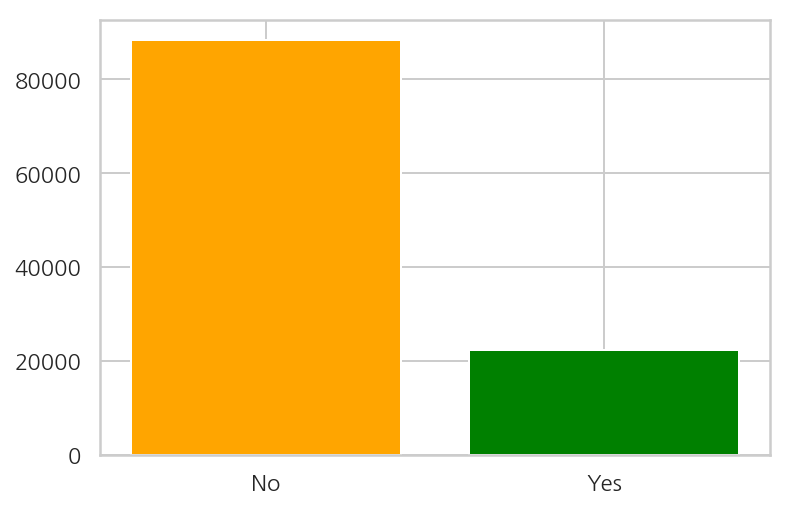

In [6]:
d1=df.groupby(["No-show"]).size().reset_index(name="count")
plt.bar(d1["No-show"], height=d1["count"], color=["orange","green"])
plt.show()

위의 그래프를 통해 우리의 데이터는 imbalanced data임을 확인할 수 있다.

### PatientId

- 데이터는 62,299명의 진료예약에 관한 정보를 담고 있음을 알 수 있다. 그러므로 동일한 인원이 받은 기록이 있음을 확인 할 수 있다.
- 전체 데이터에서 한번만 방문한 비율은 전체 데이터에서 34.3%이다.

In [7]:
print("환자들의 수 : {} 명".format(len(set(df.PatientId))))
# print("전체 데이터에서 한번만 방문한 비율 : {} %".format(round(sum(df.groupby(["PatientId"]).size() == 1)/len(df), 4)*100))

환자들의 수 : 62299 명


In [8]:
df.PatientId=df.PatientId.astype(int)

In [9]:
def cal_probNoshow(data, group_by):
    df = pd.crosstab(index = data[group_by], columns = data["No-show"]).reset_index()
    df["probNoshow"] = df["Yes"] / (df["No"] + df["Yes"])
    return df

In [10]:
Ptable=cal_probNoshow(df,"PatientId")[["PatientId", "probNoshow"]]

In [11]:
df=pd.merge(df, Ptable, how="inner", left_on=["PatientId"], right_on=["PatientId"])

### AppointmentId

- 레코드의 식별자 역할은 PatientId가 아닌 AppointmentId이다.

In [12]:
len(set(df.AppointmentID))

110527

진료예약 접수 시간에 의한 순차적인 흐름을 보이고는 있지만 전부다 일치하는 것은 아니므로 AppointmentID가 진료예약 접수 시간의 순차에 완벽하게 따른다고 할 수 없다. 그러나

In [13]:
sum(df.sort_values(by=["ScheduledDay"])["AppointmentID"].values==df.sort_values(by=["AppointmentID"])["AppointmentID"].values)

102288

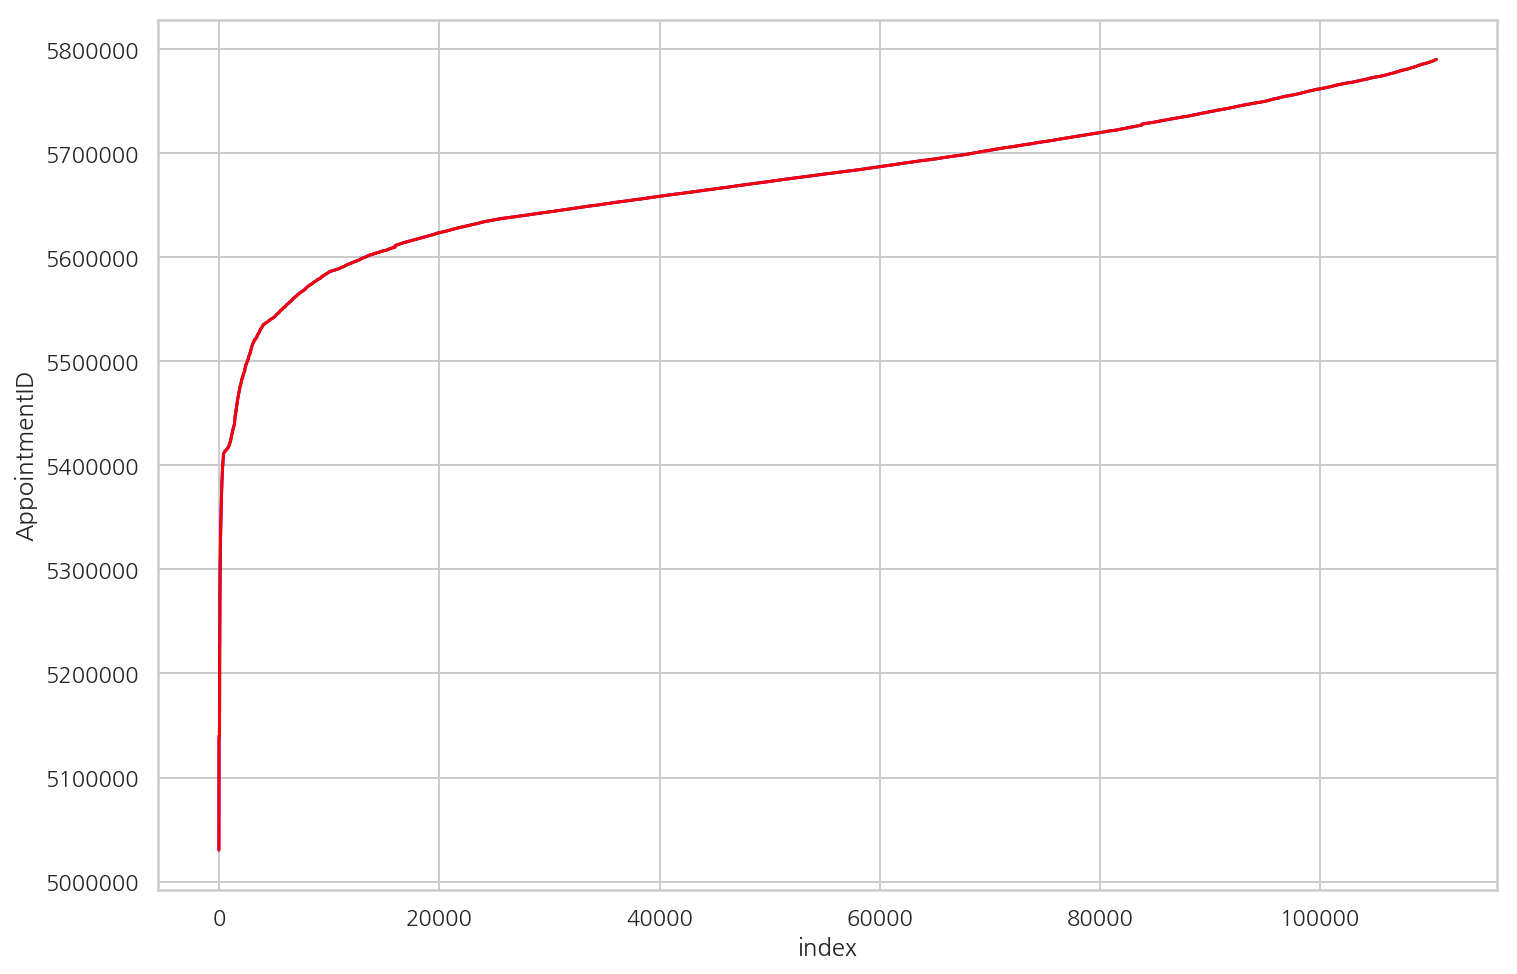

In [14]:
plt.figure(figsize=(12,8))
plt.xlabel("index")
plt.ylabel("AppointmentID")
plt.plot(df.sort_values(by=["ScheduledDay"])["AppointmentID"].values, color="blue")
plt.plot(df.sort_values(by=["AppointmentID"])["AppointmentID"].values, color="red")
plt.show()

In [15]:
def probNoshow(data, group_by):
    table=df.groupby([group_by,"No-show"]).size().reset_index(name="count")
    table=table.pivot_table(index=group_by,columns="No-show",values="count", fill_value=0)
    table["probNoshow"] = table["Yes"] / (table["No"] + table["Yes"])
    return table

In [16]:
def cal_probNoshow(data, group_by):
    df = pd.crosstab(index = data[group_by], columns = data["No-show"]).reset_index()
    df["probNoshow"] = df["Yes"] / (df["No"] + df["Yes"])
    return df

### Gender

- 전체 데이터에서 여성이 71,840명, 남성이 38,687명으로  여성이 절반이상인 약 65%를 차지하고 있음을 확인 할 수 있다.

In [17]:
df.groupby("Gender").size()/len(df)

Gender
F    0.649977
M    0.350023
dtype: float64

여성과 남성은 거의 비슷한 비율로 예약날짜에 오지 않았다는 사실을 확인 할 수 있다.

In [18]:
probNoshow(df, "Gender")

No-show,No,Yes,probNoshow
Gender,,,
F,57246,14594,0.203146
M,30962,7725,0.199679


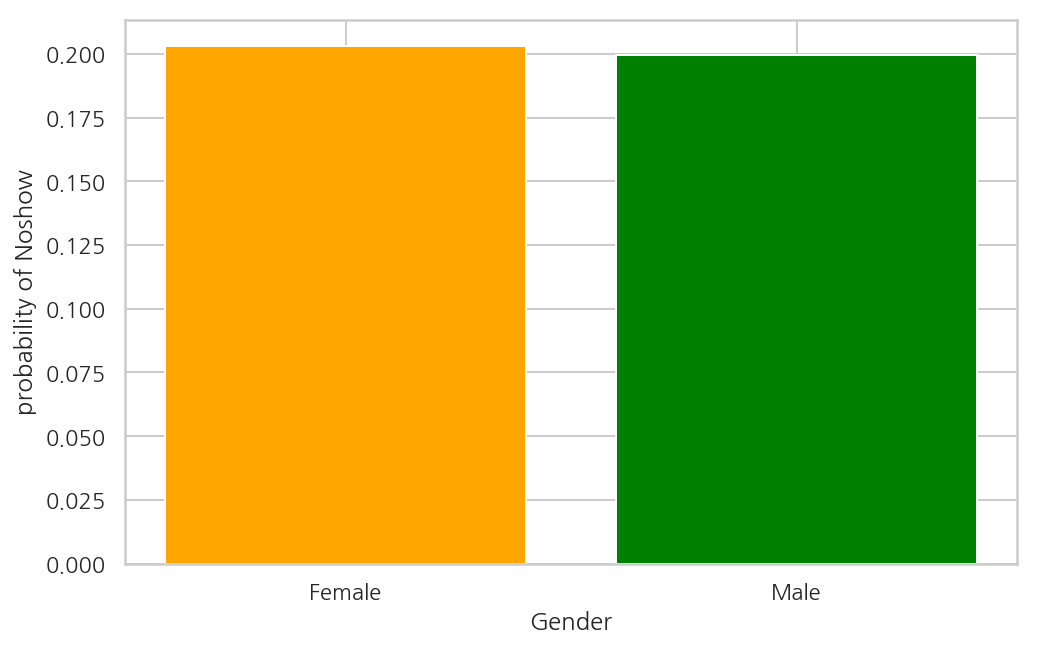

In [19]:
plt.figure(figsize=(8,5))
plt.xlabel("Gender")
plt.ylabel("probability of Noshow")
plt.bar(x=["Female","Male"], height=cal_probNoshow(df, "Gender")["probNoshow"], width=0.8, color=["orange","green"])
plt.show()

### ScheduledDay

In [20]:
# scheduledDay을 연, 월, 일, 시간, 분, 시간+분+초, 요일형태로 변환
df["scheduled_Year"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.year)
df["scheduled_month"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.month)
df["scheduled_day"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.day)
df["scheduled_Hour"] = pd.to_datetime(df.ScheduledDay).apply(lambda x: x.hour)
df["scheduled_dayofweek"] = pd.to_datetime(df.ScheduledDay)\
.apply(lambda x : calendar.weekday(x.timetuple().tm_year, x.timetuple().tm_mon, x.timetuple().tm_mday))

In [21]:
df.ScheduledDay=pd.to_datetime(df.ScheduledDay.apply(lambda x : x[:10]))

### AppointmentDay

In [22]:
df["appoint_Year"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.year)
df["appoint_month"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.month)
df["appoint_day"] = pd.to_datetime(df.AppointmentDay).apply(lambda x: x.day)
df["appoint_dayofweek"] = pd.to_datetime(df.AppointmentDay)\
.apply(lambda x : calendar.weekday(x.timetuple().tm_year, x.timetuple().tm_mon, x.timetuple().tm_mday))

In [23]:
df.AppointmentDay=pd.to_datetime(df.AppointmentDay.apply(lambda x : x[:10]))

In [33]:
Ptable=df.groupby(["PatientId"]).size().reset_index(name="total_visit_num")

In [31]:
df=pd.merge(df, Ptable, how="inner", left_on=["PatientId"], right_on=["PatientId"])

In [32]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Year', 'scheduled_month', 'scheduled_day',
       'scheduled_Hour', 'scheduled_dayofweek', 'appoint_Year',
       'appoint_month', 'appoint_day', 'appoint_dayofweek', 'total_visit_num'],
      dtype='object')

In [35]:
# cal_probNoshow(df, "total_visit_num")

진료예약을 접수한날짜를 나타내는 ScheduleDay와 진료예약 날짜를 의미하는 AppointmentDay와의 차이를 구하기 위해 다음과 같은 작업을 하였다.

In [36]:
df["differ_day"] = (df.AppointmentDay-df.ScheduledDay).apply(lambda x : x.days)

In [37]:
df.groupby(by=["differ_day","No-show"]).size().reset_index(name="count")[:8]

,differ_day,No-show,count
0,-6,Yes,1
1,-1,Yes,4
2,0,No,36771
3,0,Yes,1792
4,1,No,4100
5,1,Yes,1113
6,2,No,5123
7,2,Yes,1602


예약날짜와 예약날간의 차이가 음수인 데이터를 제거해주었다. 예약진료날에서 예약날짜의 일자를 빼주었을 때, 음수인 것은 상황이 말이 안되기 때문이다. 아마도 잘못기입되었을 가능성이 있으므로 제거해주었다.

In [38]:
df=df[df.differ_day >=0]
df.reset_index(inplace=True,drop=True)

차이가 0인 데이터들이 대다수임을 확인할 수 있다.

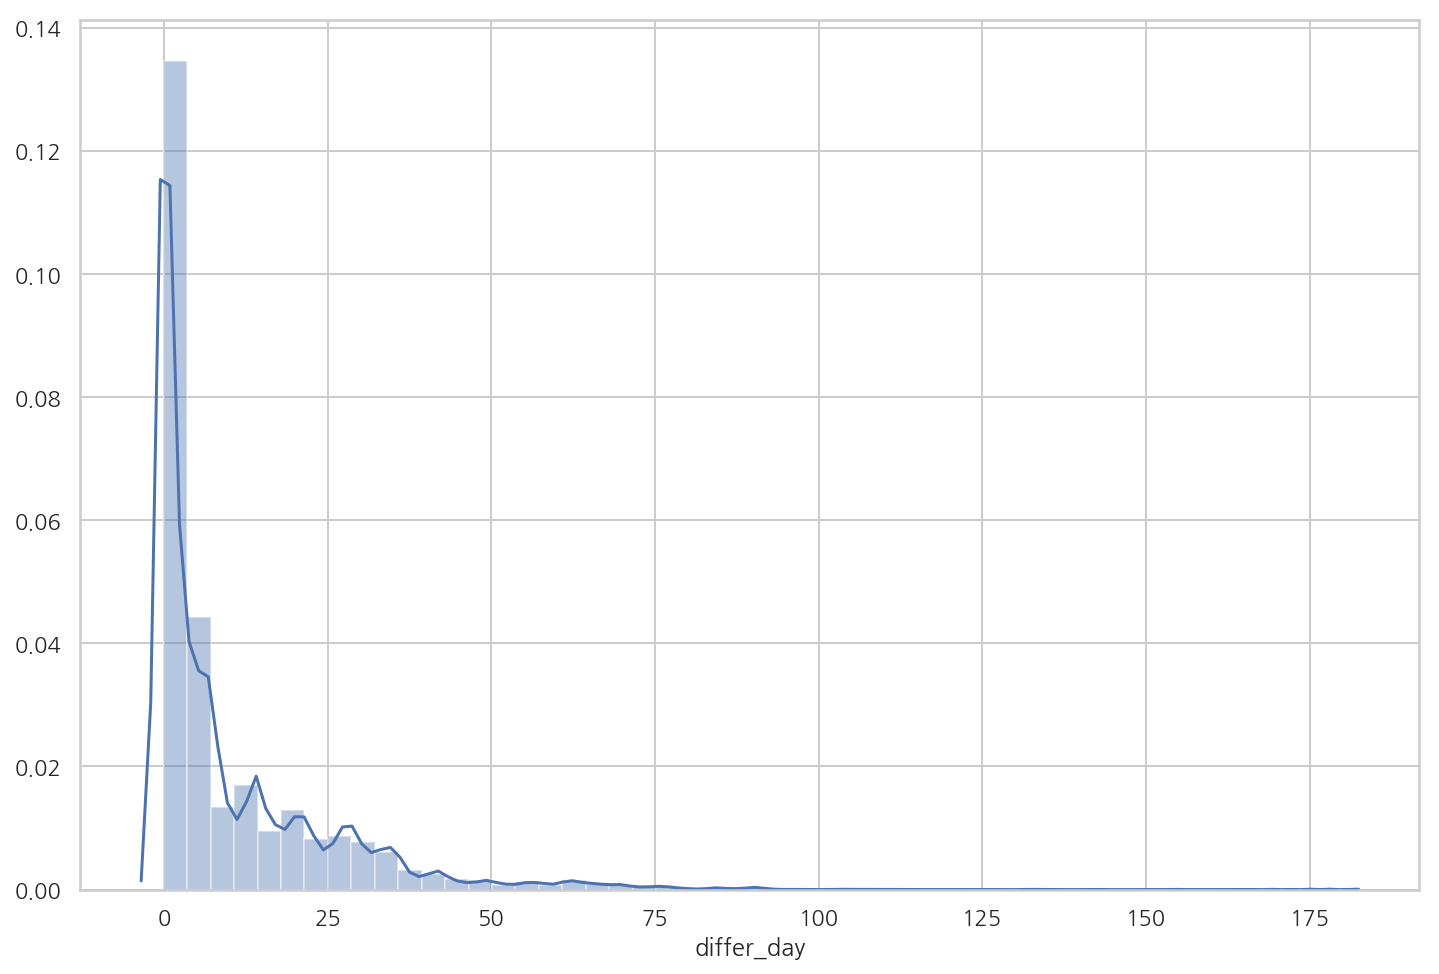

In [39]:
plt.figure(figsize=(12,8))
sns.distplot(df.differ_day)
plt.show()

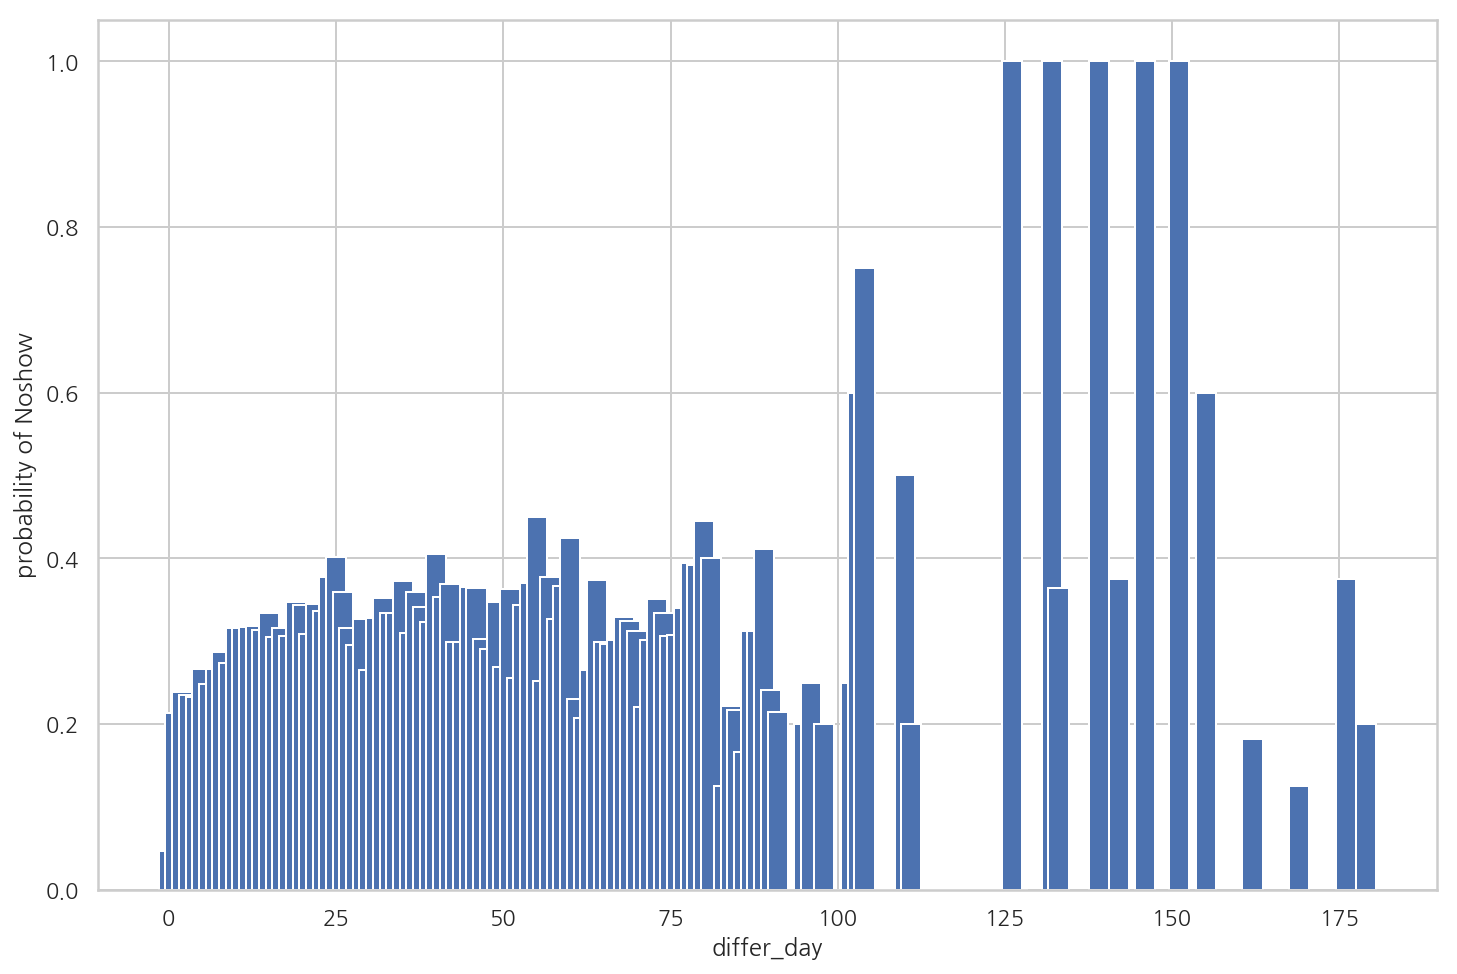

In [40]:
plt.figure(figsize=(12,8))
plt.xlabel("differ_day")
plt.ylabel("probability of Noshow")
plt.bar(x=cal_probNoshow(df, "differ_day")["differ_day"], height=cal_probNoshow(df, "differ_day")["probNoshow"], width=3)
plt.show()

In [41]:
set(df.scheduled_Year)

{2015, 2016}

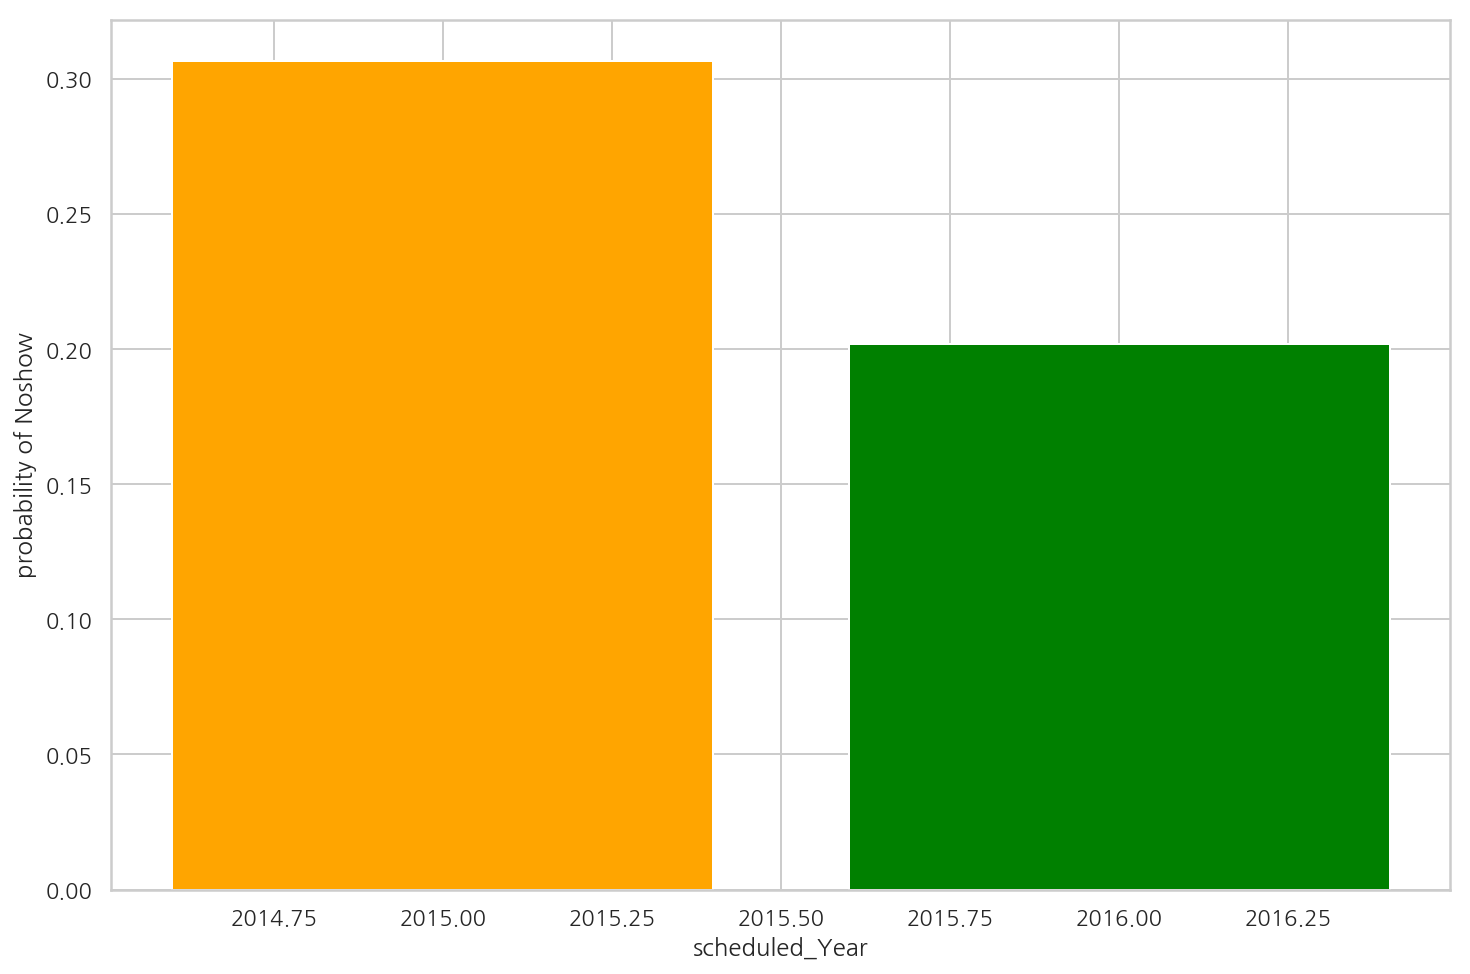

In [42]:
plt.figure(figsize=(12,8))
plt.xlabel("scheduled_Year")
plt.ylabel("probability of Noshow")
plt.bar(x=cal_probNoshow(df, "scheduled_Year")["scheduled_Year"], height=cal_probNoshow(df, "scheduled_Year")["probNoshow"], \
        width=0.8, color=["orange","green"])
plt.show()

In [43]:
set(df.scheduled_month)

{1, 2, 3, 4, 5, 6, 11, 12}

In [44]:
set(df.appoint_Year)

{2016}

실질적으로 예약을 하고 진료를 받으러오는 날은 2016년 4,5,6월의 데이터만 존재함을 확인할 수 있다.

In [45]:
set(df.appoint_month)

{4, 5, 6}

In [46]:
list(cal_probNoshow(df, "appoint_month")["appoint_month"].values)

[4, 5, 6]

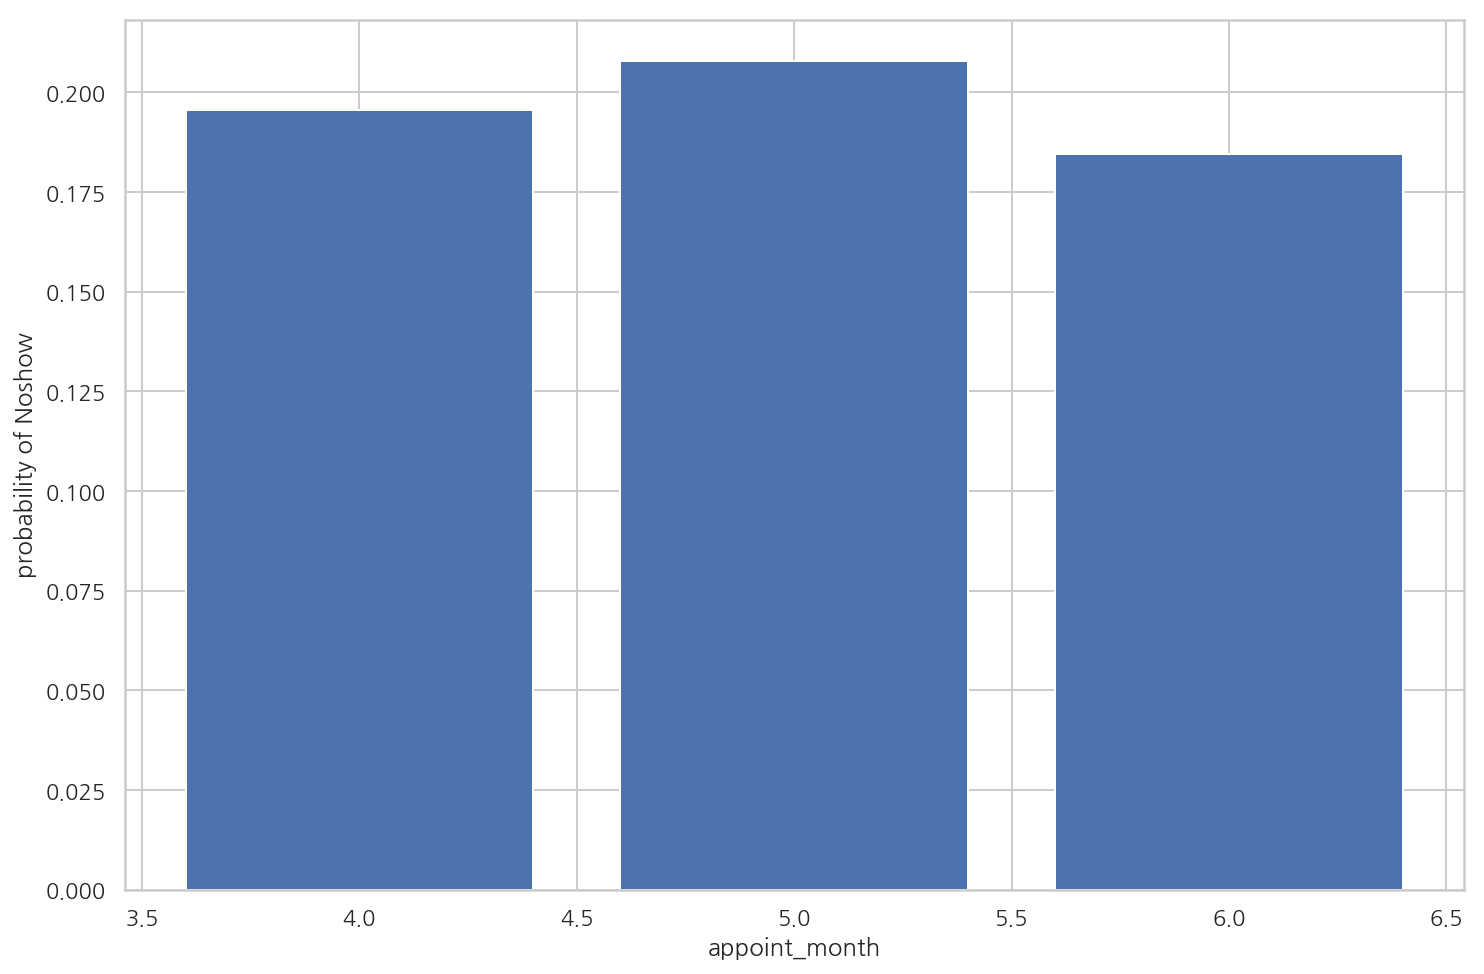

In [47]:
plt.figure(figsize=(12,8))
plt.xlabel("appoint_month")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "appoint_month")["appoint_month"].values), height=cal_probNoshow(df, "appoint_month")["probNoshow"], width=0.8)
# plt.xticks(list(cal_probNoshow(df, "appoint_month")["appoint_month"].values), ["4","5","6"])
plt.show()

In [48]:
set(df.appoint_dayofweek)

{0, 1, 2, 3, 4, 5}

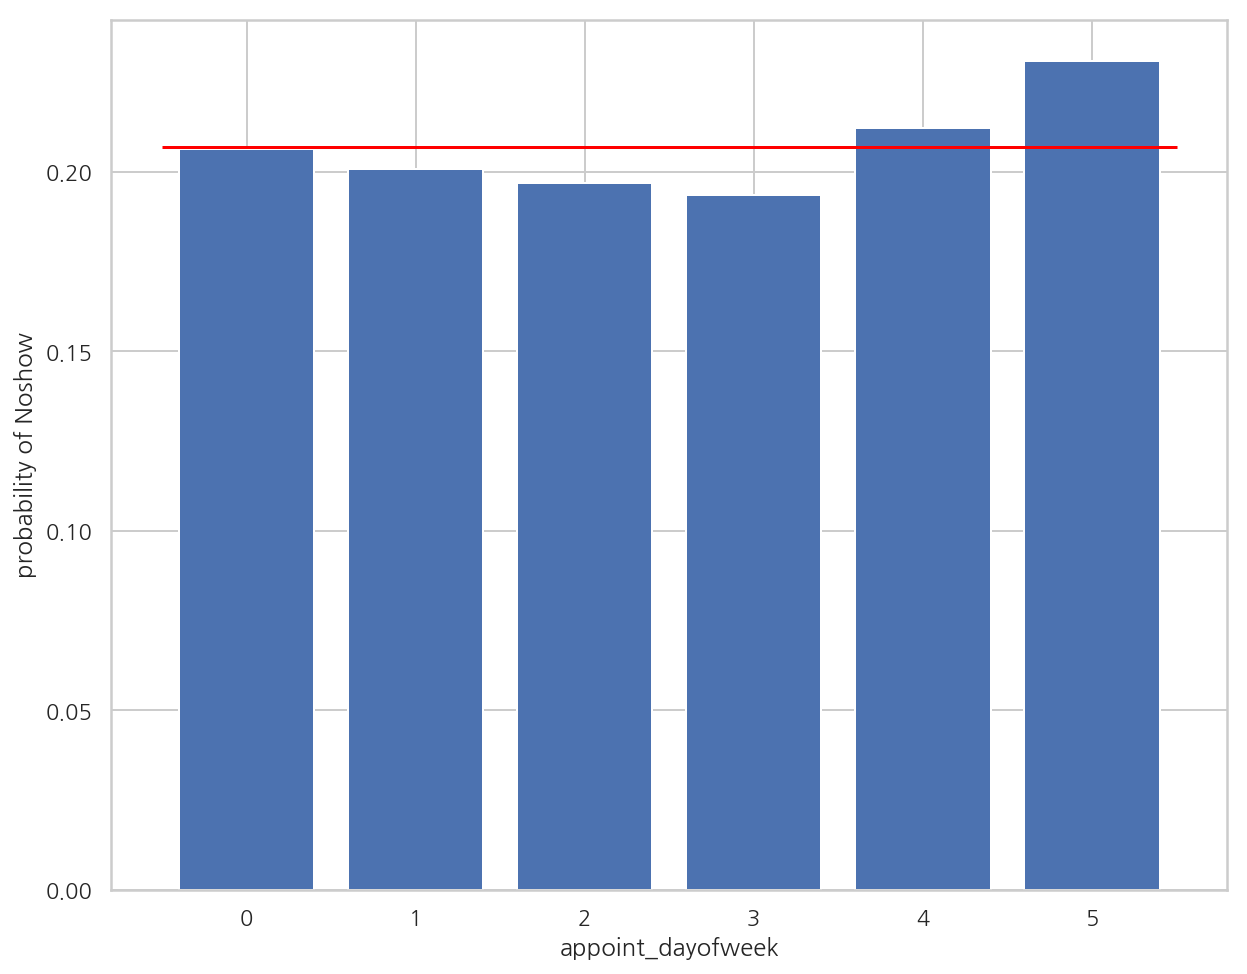

In [49]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.xlabel("appoint_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "appoint_dayofweek")["appoint_dayofweek"].values), height=cal_probNoshow(df, "appoint_dayofweek")["probNoshow"], width=0.8)
ax.hlines(np.mean(cal_probNoshow(df, "appoint_dayofweek")["probNoshow"]),-0.5,5.5,color="red")
plt.show()

In [50]:
df["new_appoint_dayofweek"] = df.scheduled_dayofweek.apply(lambda x : 0 if x <= 3 else 1)

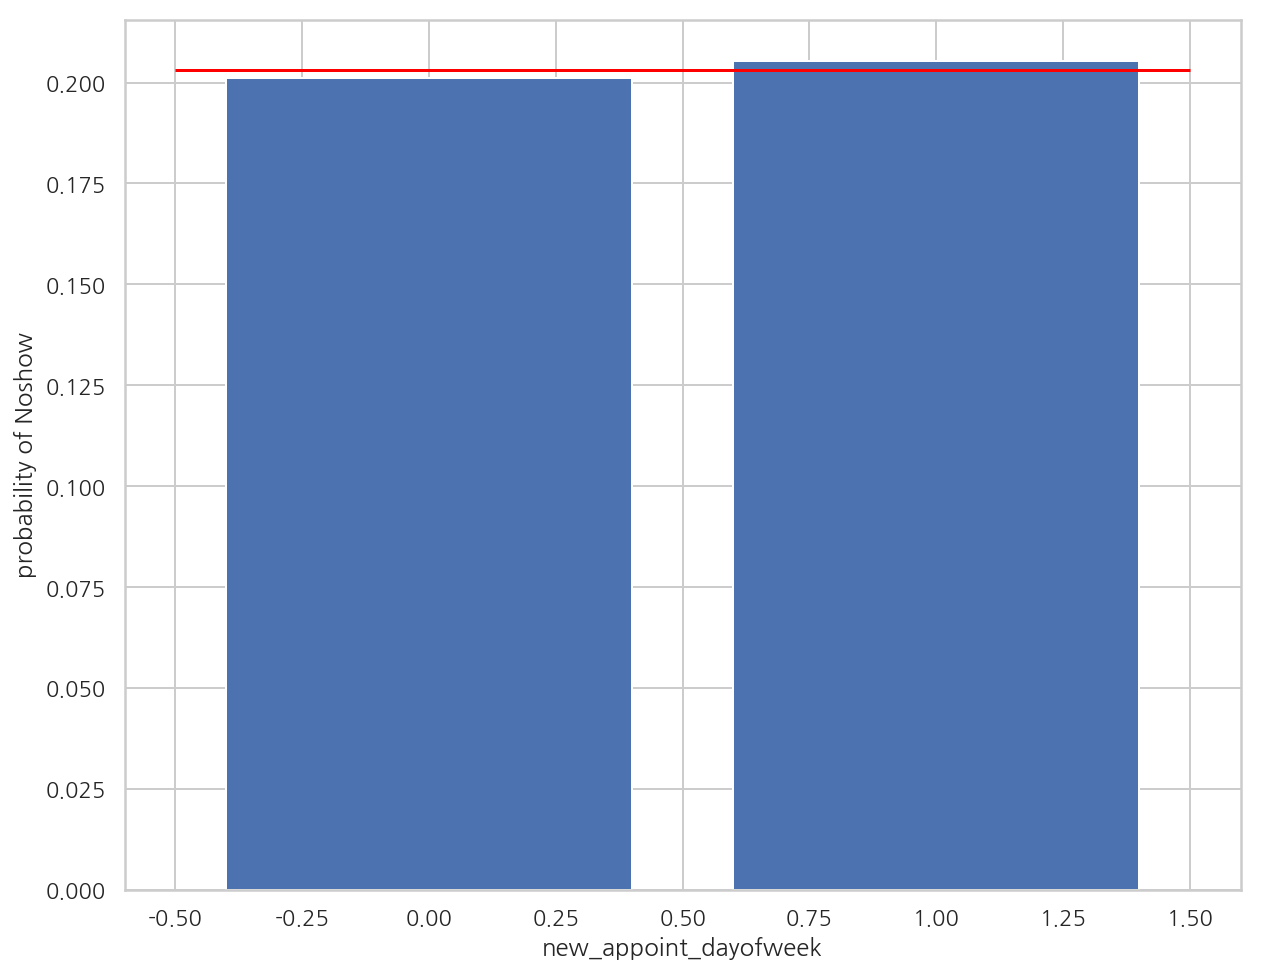

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.xlabel("new_appoint_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "new_appoint_dayofweek")["new_appoint_dayofweek"].values), height=cal_probNoshow(df, "new_appoint_dayofweek")["probNoshow"], width=0.8)
ax.hlines(np.mean(cal_probNoshow(df, "new_appoint_dayofweek")["probNoshow"]),-0.5,1.5,color="red")
plt.show()

In [52]:
df=df.drop(columns=["new_appoint_dayofweek"])

In [53]:
set(df.scheduled_dayofweek)

{0, 1, 2, 3, 4, 5}

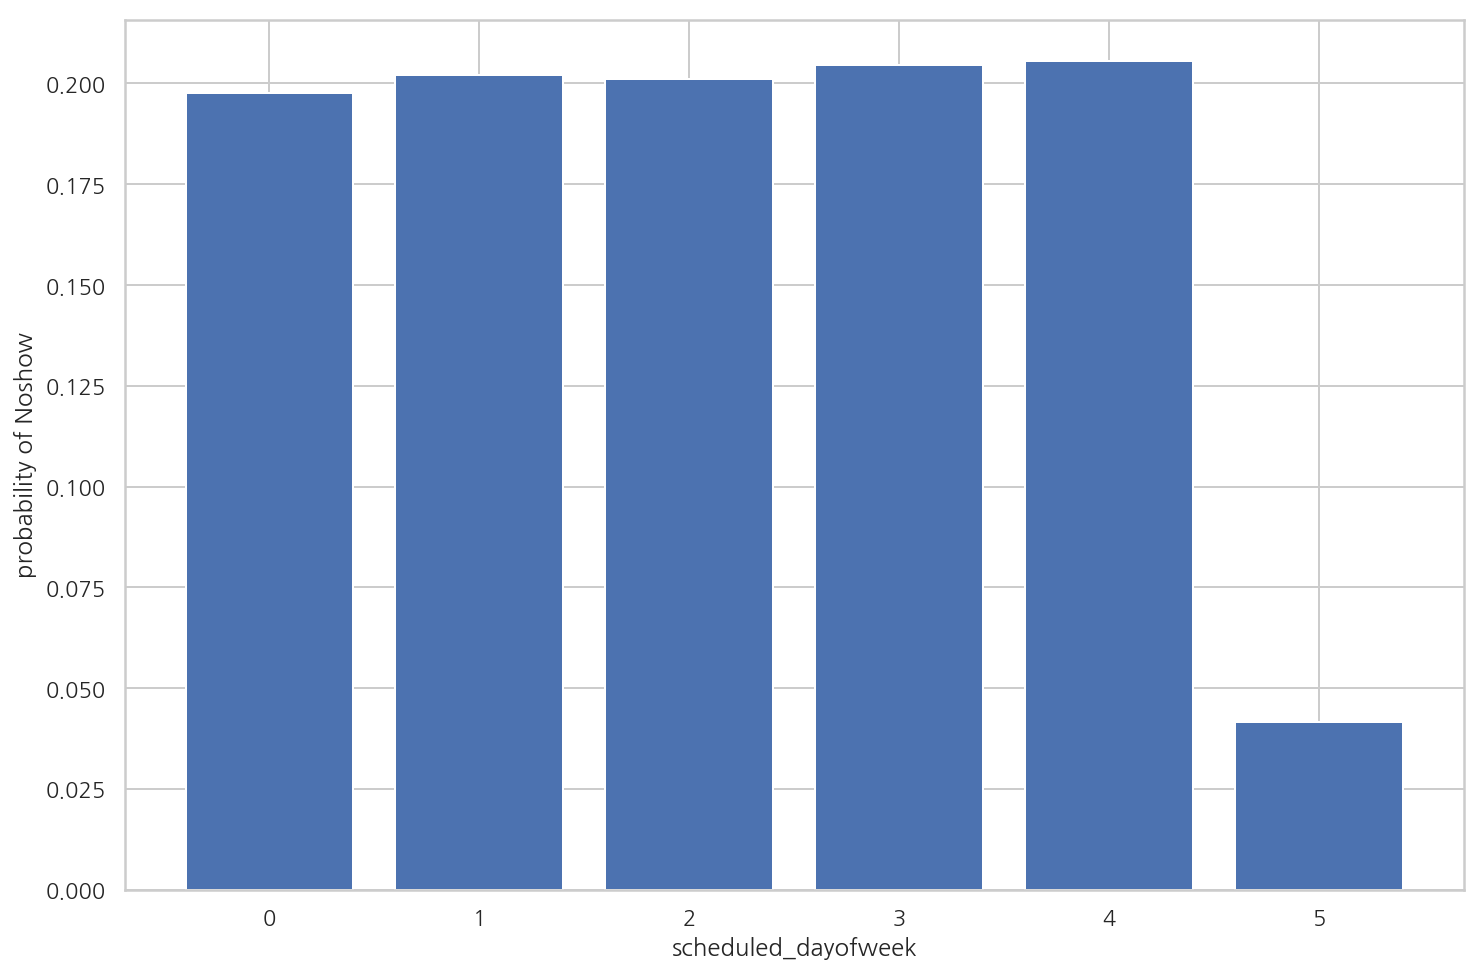

In [54]:
plt.figure(figsize=(12,8))
plt.xlabel("scheduled_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "scheduled_dayofweek")["scheduled_dayofweek"].values), height=cal_probNoshow(df, "scheduled_dayofweek")["probNoshow"], width=0.8)
plt.show()

In [55]:
df["new_scheduled_dayofweek"] = df.scheduled_dayofweek.apply(lambda x : 0 if x <= 4 else 1)

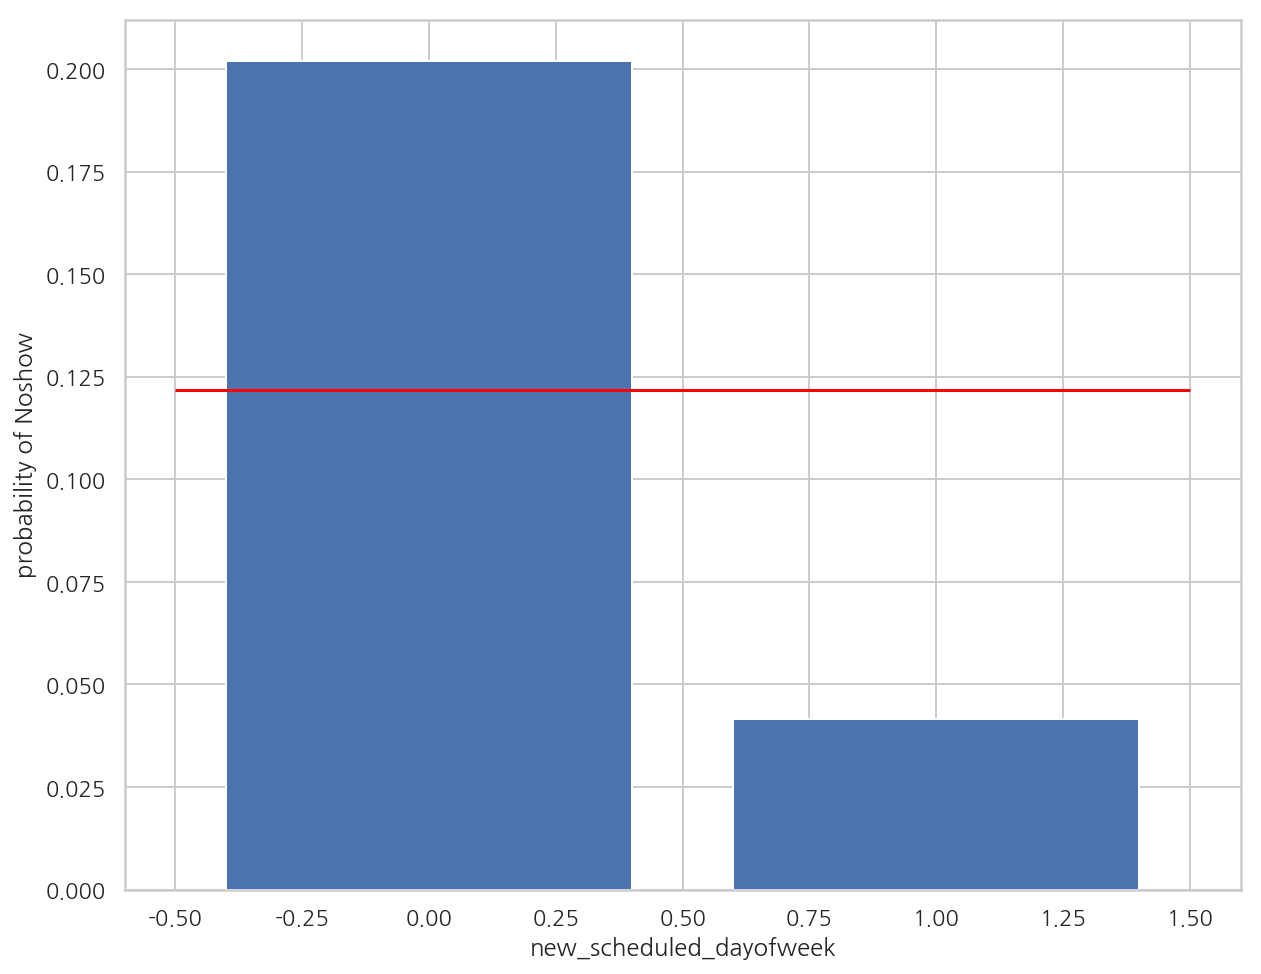

In [56]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.xlabel("new_scheduled_dayofweek")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "new_scheduled_dayofweek")["new_scheduled_dayofweek"].values), height=cal_probNoshow(df, "new_scheduled_dayofweek")["probNoshow"], width=0.8)
ax.hlines(np.mean(cal_probNoshow(df, "new_scheduled_dayofweek")["probNoshow"]),-0.5,1.5,color="red")
plt.show()

In [57]:
df=df.drop(columns=["new_scheduled_dayofweek"])

In [58]:
set(df.scheduled_Hour)

{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

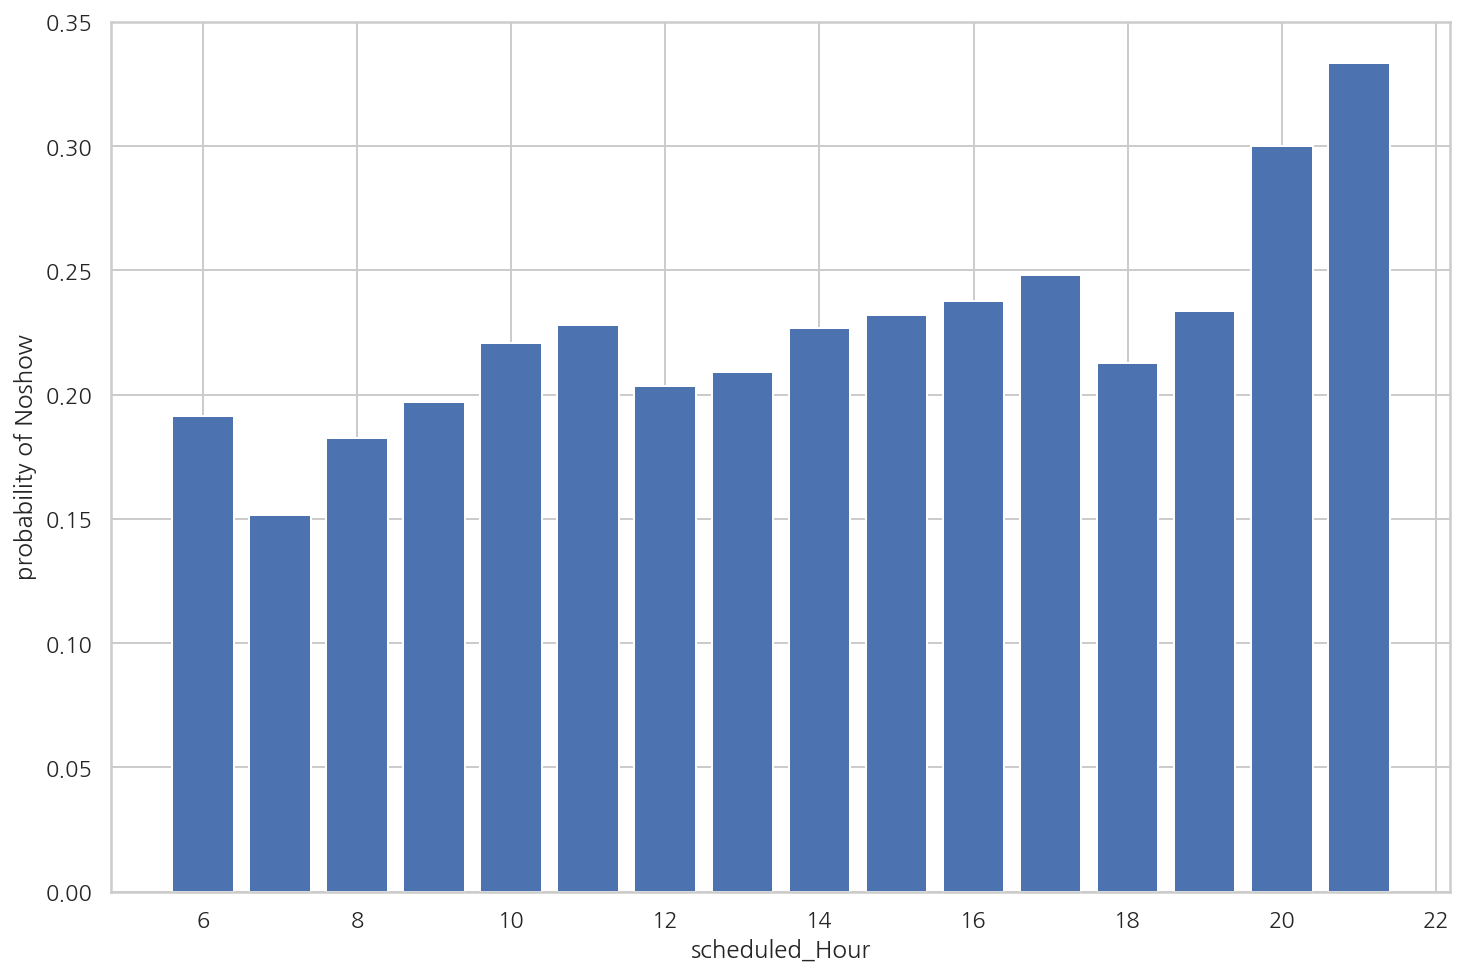

In [59]:
plt.figure(figsize=(12,8))
plt.xlabel("scheduled_Hour")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "scheduled_Hour")["scheduled_Hour"].values), height=cal_probNoshow(df, "scheduled_Hour")["probNoshow"], width=0.8)
plt.show()

In [60]:
np.mean(pd.crosstab(index=df.AppointmentDay,columns=df["No-show"])["Yes"])

826.4444444444445

In [61]:
np.mean(pd.crosstab(index=df.AppointmentDay,columns=df["No-show"])["No"])

3266.962962962963

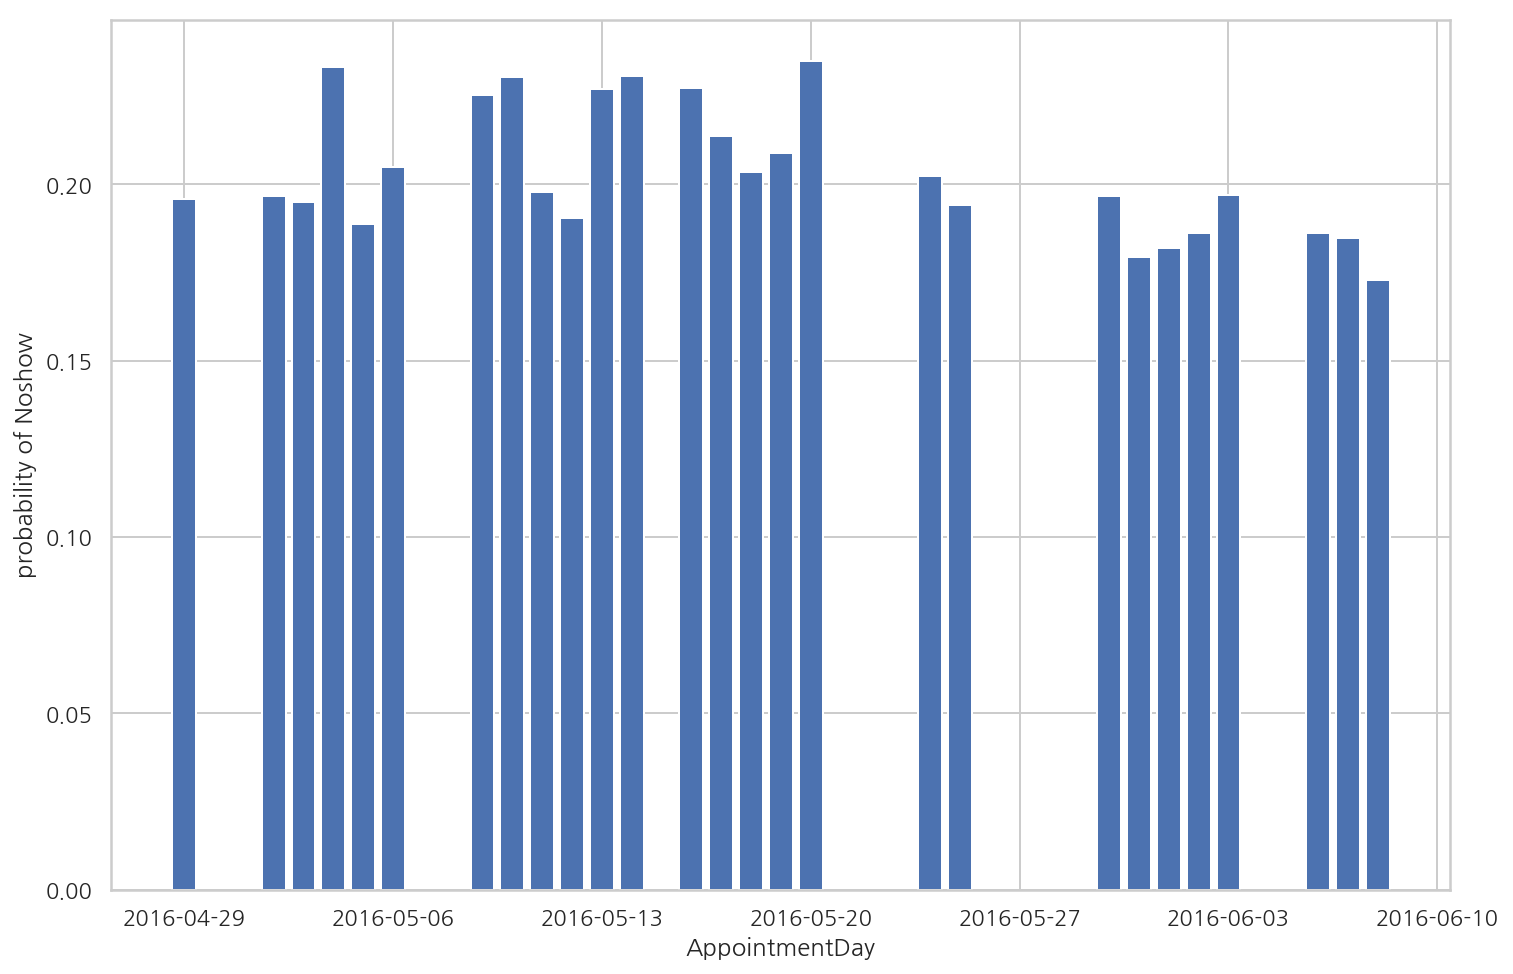

In [62]:
plt.figure(figsize=(12,8))
plt.xlabel("AppointmentDay")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "AppointmentDay")["AppointmentDay"].values), height=cal_probNoshow(df, "AppointmentDay")["probNoshow"], width=0.8)
plt.show()

만약 범주를 나눈다면 월,화,수를 하나의 범주로 그리고 목,금을 하나의 범주, 나머지 토요일을 하나의 범주로 나누어야 할 것 같다는 생각이든다.

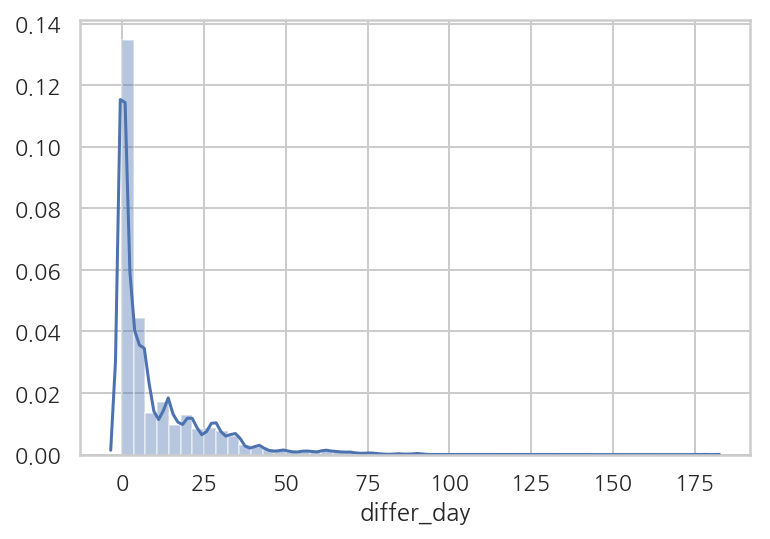

In [63]:
sns.distplot(df.differ_day)
plt.show()

In [64]:
df.differ_day.describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: differ_day, dtype: float64

In [65]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Year', 'scheduled_month', 'scheduled_day',
       'scheduled_Hour', 'scheduled_dayofweek', 'appoint_Year',
       'appoint_month', 'appoint_day', 'appoint_dayofweek', 'total_visit_num',
       'differ_day'],
      dtype='object')

In [66]:
df[df.differ_day<16][df["No-show"]=="Yes"].groupby(["SMS_received"]).size()/len(df[df.differ_day<16][df["No-show"]=="Yes"])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


SMS_received
0    0.635907
1    0.364093
dtype: float64

In [67]:
df[df.differ_day<16].groupby(["SMS_received","No-show"]).size()/len(df[df.differ_day<16])

SMS_received  No-show
0             No         0.665314
              Yes        0.103600
1             No         0.171769
              Yes        0.059317
dtype: float64

In [68]:
df[df.differ_day<16].groupby(["No-show"]).size()/len(df[df.differ_day<16])

No-show
No     0.837083
Yes    0.162917
dtype: float64

In [69]:
df[df.differ_day>=16].groupby(["SMS_received","No-show"]).size()/len(df[df.differ_day>=16])

SMS_received  No-show
0             No         0.245371
              Yes        0.144746
1             No         0.427570
              Yes        0.182313
dtype: float64

In [70]:
df[df.differ_day>=16][df["No-show"]=="Yes"].groupby(["SMS_received"]).size()/len(df[df.differ_day>=16][df["No-show"]=="Yes"])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


SMS_received
0    0.442568
1    0.557432
dtype: float64

In [71]:
df[df.differ_day>=16].groupby(["No-show"]).size()/len(df[df.differ_day>=16])

No-show
No     0.672941
Yes    0.327059
dtype: float64

### Age

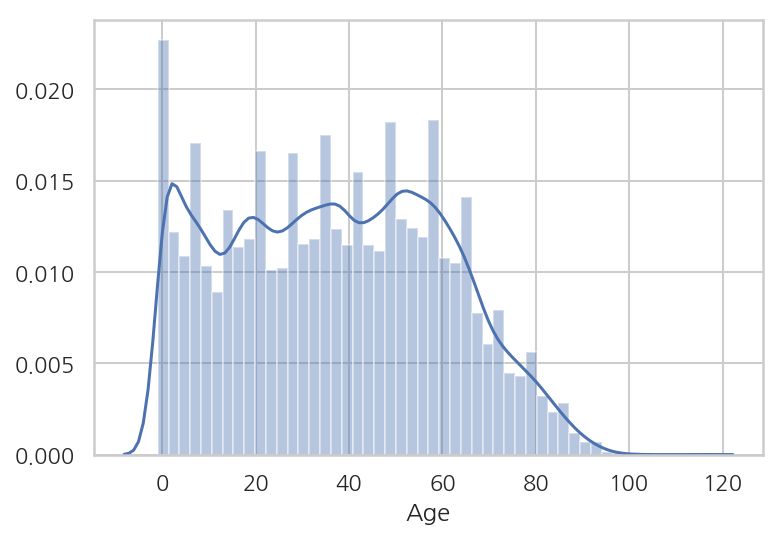

In [72]:
sns.distplot(df.Age)
plt.show()

In [73]:
sum(df.Age==-1)

1

In [74]:
np.where(df.Age==-1)

(array([106723]),)

여성이므로 나이가 -1인것은 임산부가 태아의 진료를 받으려고 예약한 자료라고 추측 해 볼 수 있을 것이다. 허나 정확히 임산부인지를 알 수 있을 만한 자료가 -1인 데이터가 하나만 존재하며 이 데이터의 PatientId와 동일한 다른 데이터가 있는지 확인 한 후에 있다면 그 데이터의 나이를 확인해 보려 하였으나, 데이터가 임산부의 데이터라는 것을 뒷받침할만한 근거가 없으므로 제거해줄것이다. 

결론적으로 0세이상인 데이터만을 사용할 것이다.

In [75]:
df.iloc[99827][0]

961558366325976

In [76]:
np.where(df.PatientId==465943158731293.0)

(array([106723]),)

In [77]:
sum(df.Age==0)

3539

In [78]:
df=df[df.Age >=0]

In [79]:
df.reset_index(inplace=True,drop=True)
df.index

RangeIndex(start=0, stop=110521, step=1)

또한 100세 이상의 데이터가 있는데 이것은 의료 기술의 발달로 인해 충분히 가능할 것이라는 판단으로 데이터를 제거하지 않을 것이다.

In [80]:
df.iloc[np.where(df.Age > 100)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,scheduled_month,scheduled_day,scheduled_Hour,scheduled_dayofweek,appoint_Year,appoint_month,appoint_day,appoint_dayofweek,total_visit_num,differ_day
76461,976294799775439,5651757,F,2016-05-03,2016-05-03,102,CONQUISTA,0,0,0,...,5,3,9,1,2016,5,3,1,1,0
82300,31963211613981,5700278,F,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,...,5,16,9,0,2016,5,19,3,4,3
82301,31963211613981,5700279,F,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,...,5,16,9,0,2016,5,19,3,4,3
82302,31963211613981,5562812,F,2016-04-08,2016-05-16,115,ANDORINHAS,0,0,0,...,4,8,14,4,2016,5,16,0,4,38
82303,31963211613981,5744037,F,2016-05-30,2016-05-30,115,ANDORINHAS,0,0,0,...,5,30,9,0,2016,5,30,0,4,0
102280,234283596548,5751563,F,2016-05-31,2016-06-02,102,MARIA ORTIZ,0,0,0,...,5,31,10,1,2016,6,2,3,1,2
105768,748234579244724,5717451,F,2016-05-19,2016-06-03,115,SÃO JOSÉ,0,1,0,...,5,19,7,3,2016,6,3,4,1,15


PatientId가 나이에 상관이 있는지 확인해 보기 위해 비교해본 결과 다음과 같이 나이에 영향을 받고 있지 않음을 확인할 수 있다.

In [81]:
sum(df.sort_values(by=["Age"])["PatientId"].values==df.sort_values(by=["PatientId"])["PatientId"].values)

2

예상했던것과는 달리 PatientId는 예약한 지역과의 연관지어진 의미였다. 아래를 살펴보게되면 지역이 동일한 곳의 PatientID가 비슷하다는 것을 확인 할 수 있다. 그러나 지역의 코드를 품고있으면서, 그 데이터 각각의 식별자를 의미하는 것이므로 PatientId는 결론적으로 우리의 분석에 중요하지 않은 변수임을 확인할 수 있다.

In [82]:
df.sort_values(by=["PatientId"])

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,scheduled_month,scheduled_day,scheduled_Hour,scheduled_dayofweek,appoint_Year,appoint_month,appoint_day,appoint_dayofweek,total_visit_num,differ_day
107020,39217,5751990,F,2016-05-31,2016-06-03,44,PRAIA DO SUÁ,0,0,0,...,5,31,10,1,2016,6,3,4,1,3
108911,43741,5760144,M,2016-06-01,2016-06-01,39,MARIA ORTIZ,0,0,1,...,6,1,14,2,2016,6,1,2,1,0
10185,93779,5712759,F,2016-05-18,2016-05-18,33,CENTRO,0,0,0,...,5,18,9,2,2016,5,18,2,1,0
90210,141724,5637648,M,2016-04-29,2016-05-02,12,FORTE SÃO JOÃO,0,0,0,...,4,29,7,4,2016,5,2,0,1,3
90145,537615,5637728,F,2016-04-29,2016-05-06,14,FORTE SÃO JOÃO,0,0,0,...,4,29,7,4,2016,5,6,4,1,7
73619,5628261,5680449,M,2016-05-10,2016-05-13,13,PARQUE MOSCOSO,0,0,0,...,5,10,11,1,2016,5,13,4,1,3
59198,11831856,5718578,M,2016-05-19,2016-05-19,16,SANTO ANTÔNIO,0,0,0,...,5,19,9,3,2016,5,19,3,1,0
77122,22638656,5580835,F,2016-04-14,2016-05-03,22,INHANGUETÁ,0,0,0,...,4,14,7,3,2016,5,3,1,2,19
77123,22638656,5715081,F,2016-05-18,2016-06-08,23,INHANGUETÁ,0,0,0,...,5,18,13,2,2016,6,8,2,2,21
68624,52168938,5704816,F,2016-05-16,2016-05-16,28,JARDIM DA PENHA,0,0,0,...,5,16,16,0,2016,5,16,0,2,0


In [83]:
def cal_probNoshow(data, group_by):
    df = pd.crosstab(index = data[group_by], columns = data["No-show"]).reset_index()
    df["probNoshow"] = df["Yes"] / (df["No"] + df["Yes"])
    return df

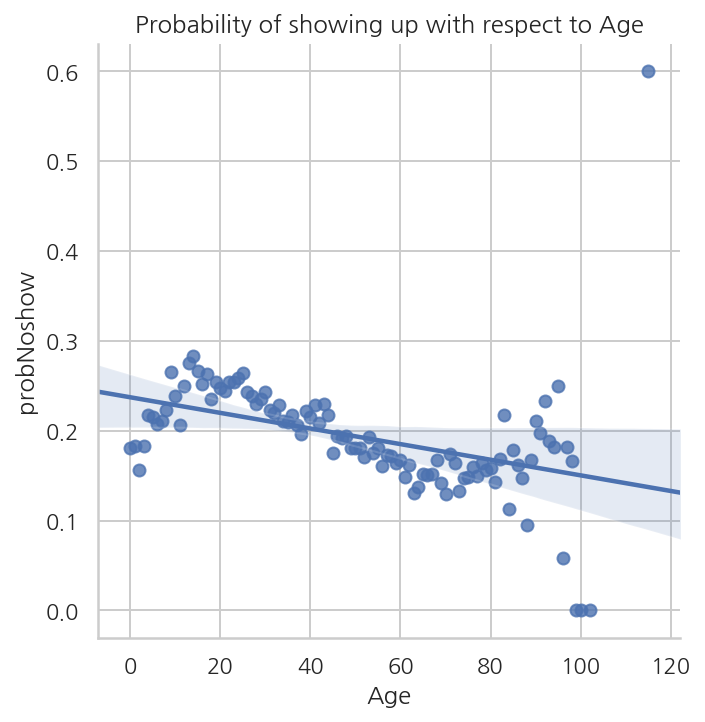

In [84]:
sns.lmplot(data = cal_probNoshow(df, 'Age'), x = 'Age', y = 'probNoshow', fit_reg = True)
# plt.xlim(0, 100)
plt.title('Probability of showing up with respect to Age')
plt.show()

브라질의 성년의 기준은 우리나라와 달리 18세이다. 위의 그래프를 살펴보게되면, 대략 18세를 기준으로 18세 이전까지는 보호자의 동행에 따라 자신의 의지보다는 보호자의 스케줄에 따라 가능한 시간대에 예약을 접수했을 확률이 크기 때문에 0세에서 18세로 갈수록 예약접수를 한 후 진료를 받으러 오지 않을 확률이 크다는 것을 확인할 수 있다.

### Neighbourhood

- 예약한 병원의 장소

In [85]:
len(set(df.Neighbourhood)) # 81개의 지역정보

81

In [86]:
def city_count():
    data=df.groupby(["Neighbourhood"]).size().reset_index(name="count")
    return data

<BarContainer object of 81 artists>

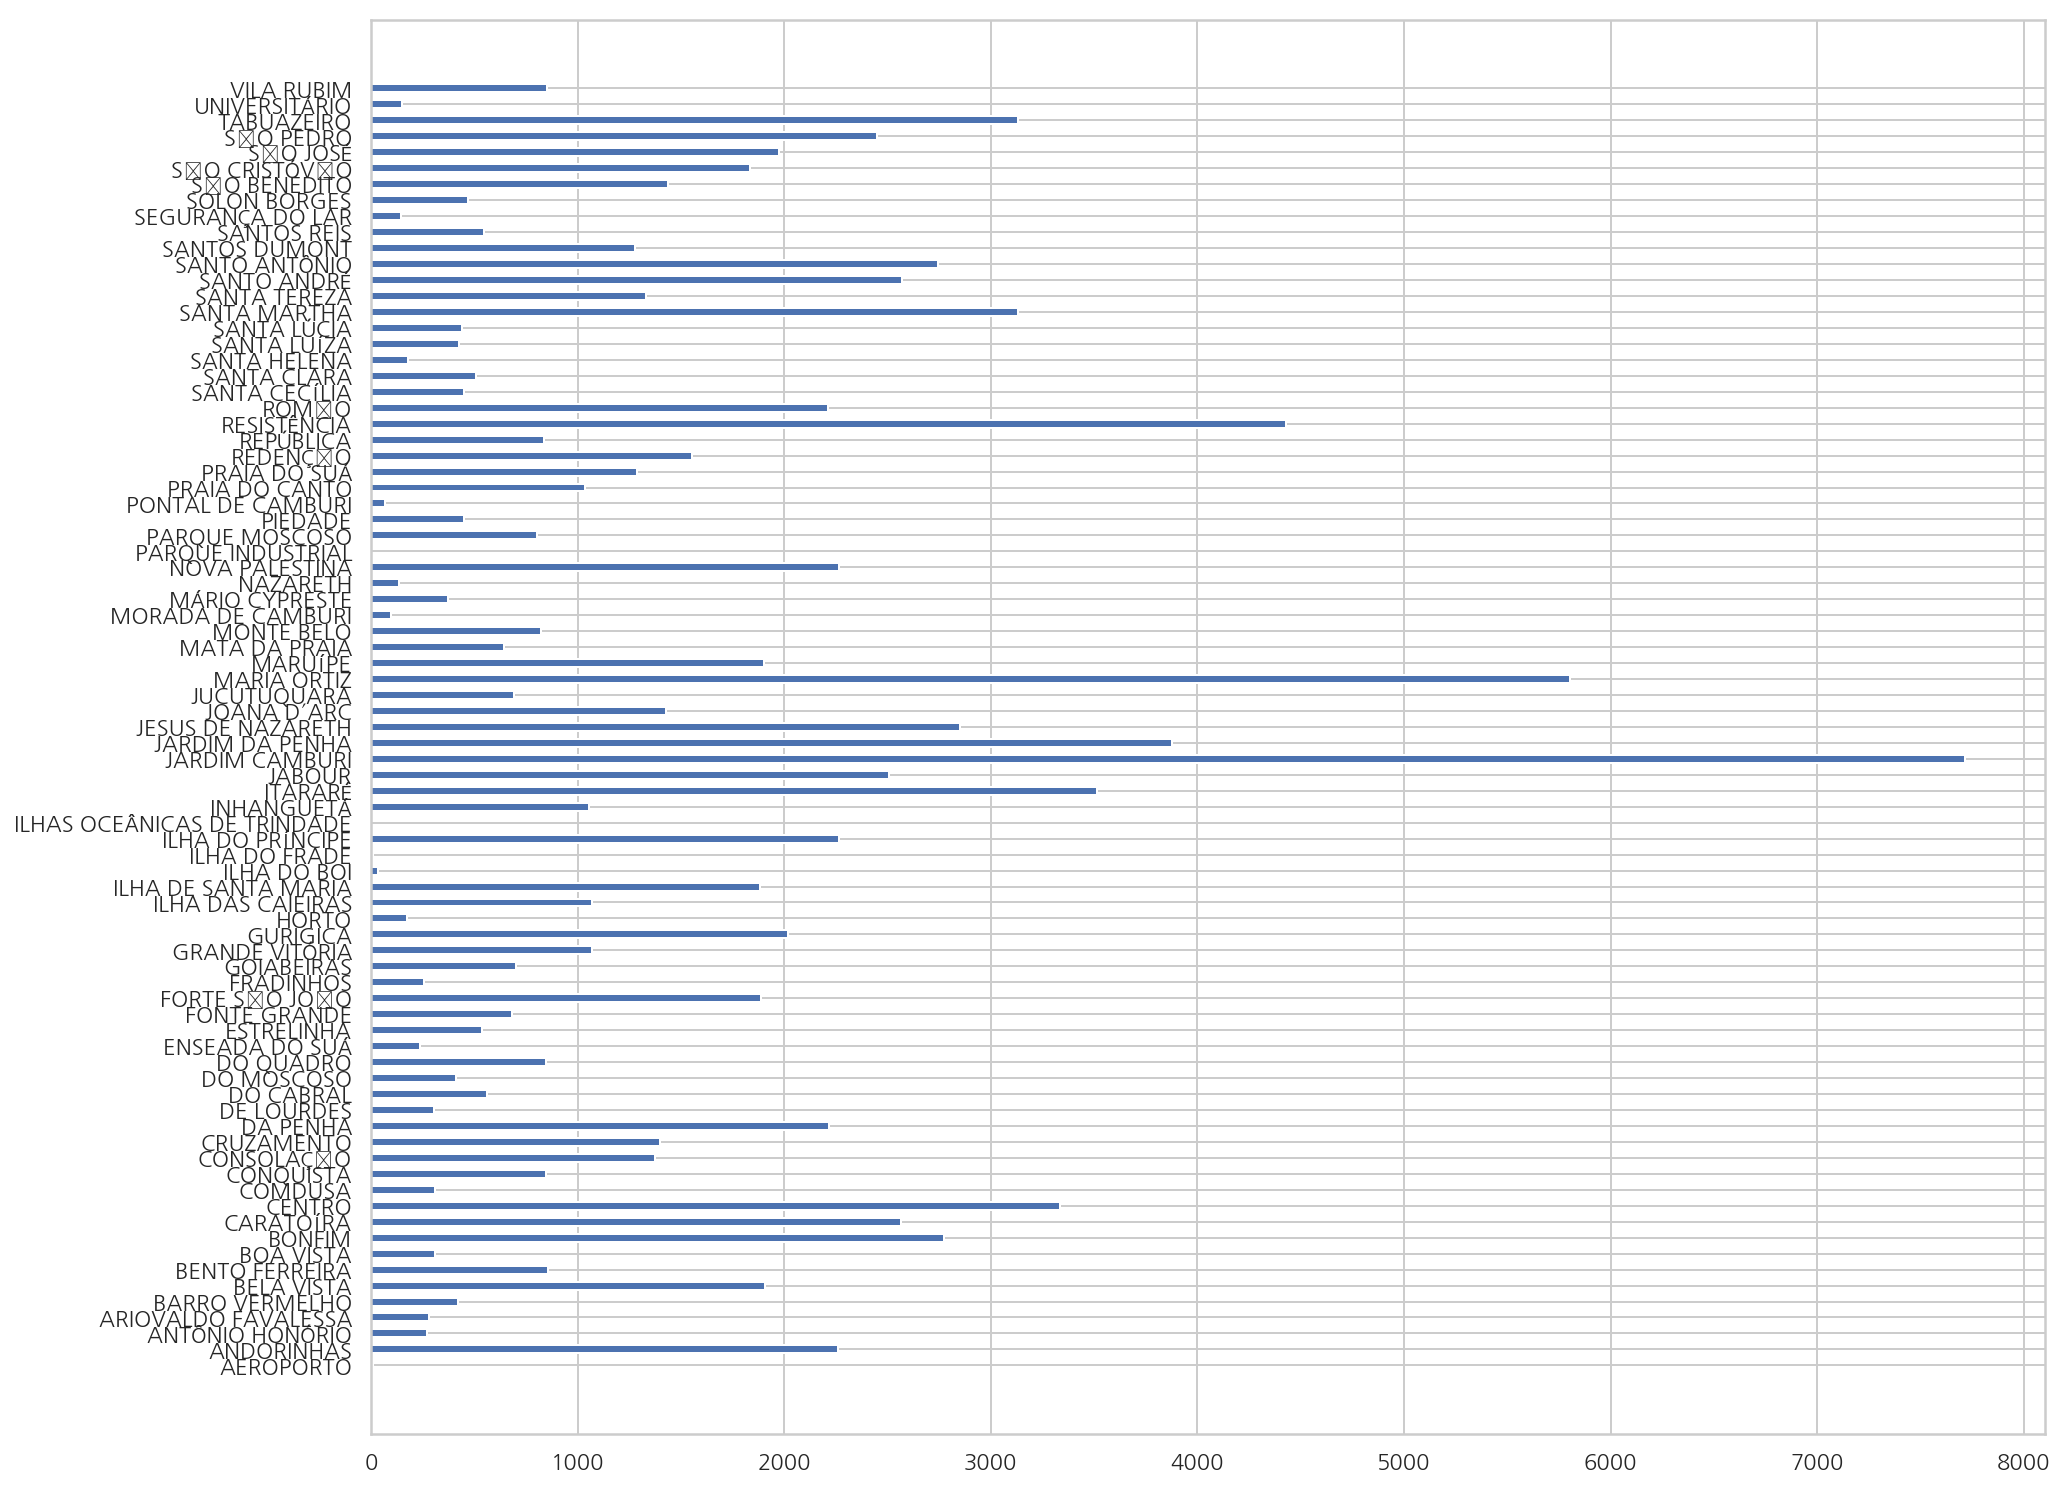

In [87]:
fig = plt.figure(figsize=(15, 13))
plt.barh(city_count()["Neighbourhood"], width=city_count()["count"], height=0.5, align='center')

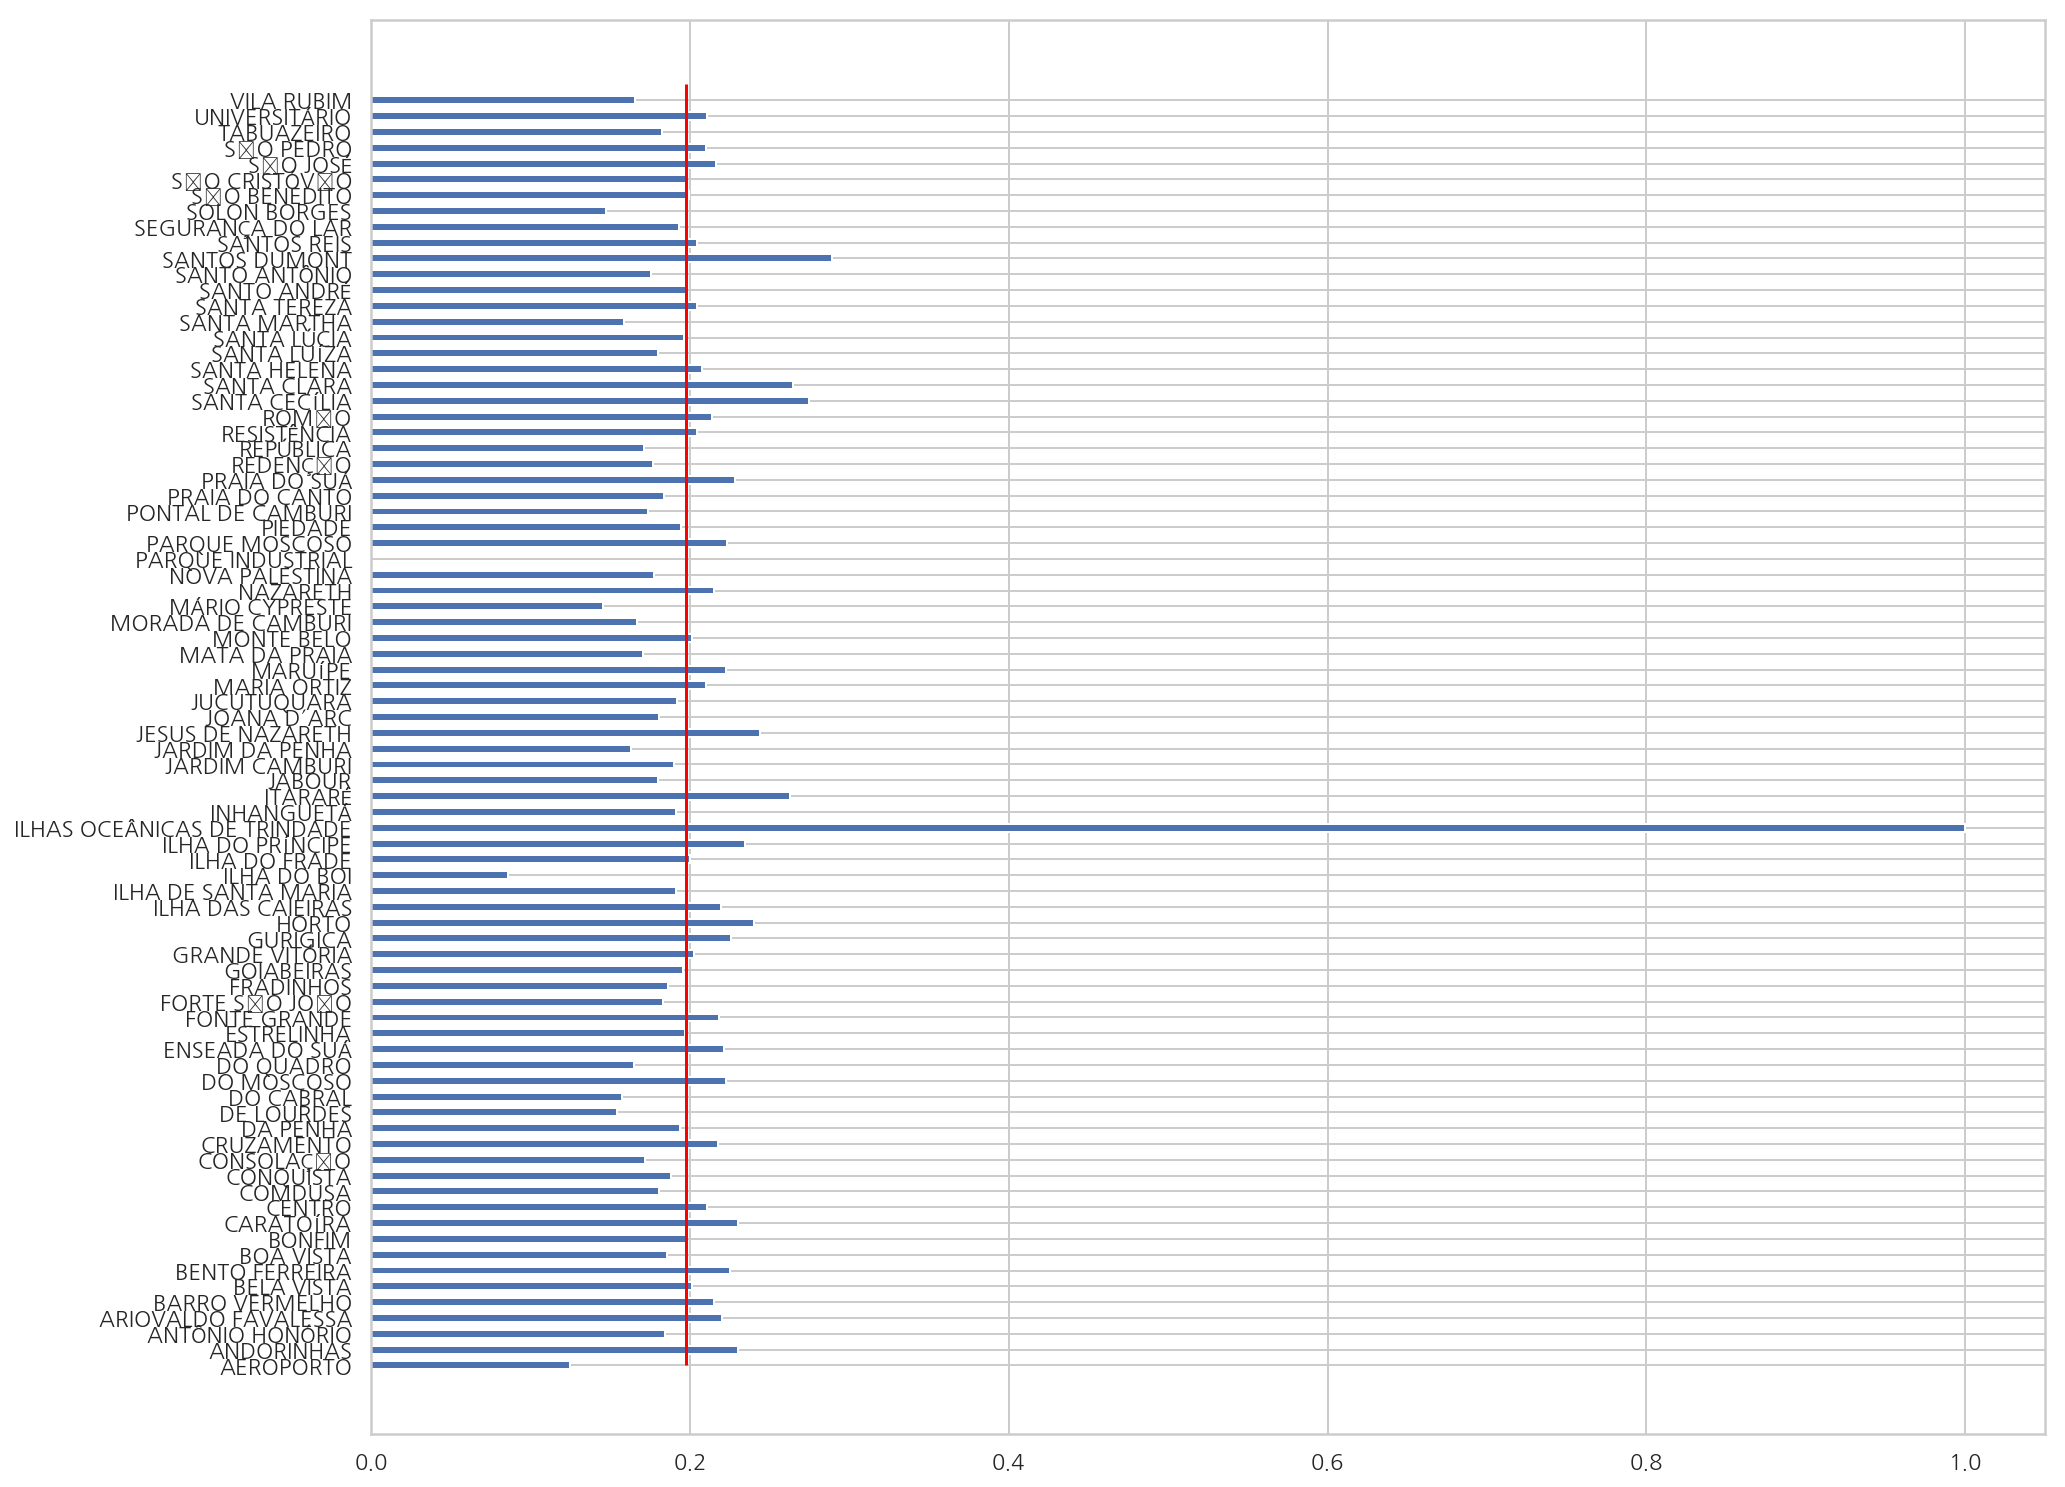

In [88]:
fig, ax = plt.subplots(1,1,figsize=(15,13))
plt.barh(cal_probNoshow(df, "Neighbourhood")["Neighbourhood"], width=cal_probNoshow(df, "Neighbourhood")["probNoshow"], \
         height=0.5, align='center')
ax.vlines(np.median(cal_probNoshow(df, "Neighbourhood")["probNoshow"]),0,81,color="red")


### Scholarship

- 정부의 사회 복지 프로그램 중 하나로써, 학교를 다니고 있는 아이들이 있는 
- 정부의 복지금을 받지 않고 있는 환자들이 많다는 것을 확인 할 수 있다.

In [89]:
df.groupby("Scholarship").size()

Scholarship
0    99660
1    10861
dtype: int64

In [90]:
df.groupby(["Scholarship","No-show"]).size()

Scholarship  No-show
0            No         79924
             Yes        19736
1            No          8283
             Yes         2578
dtype: int64

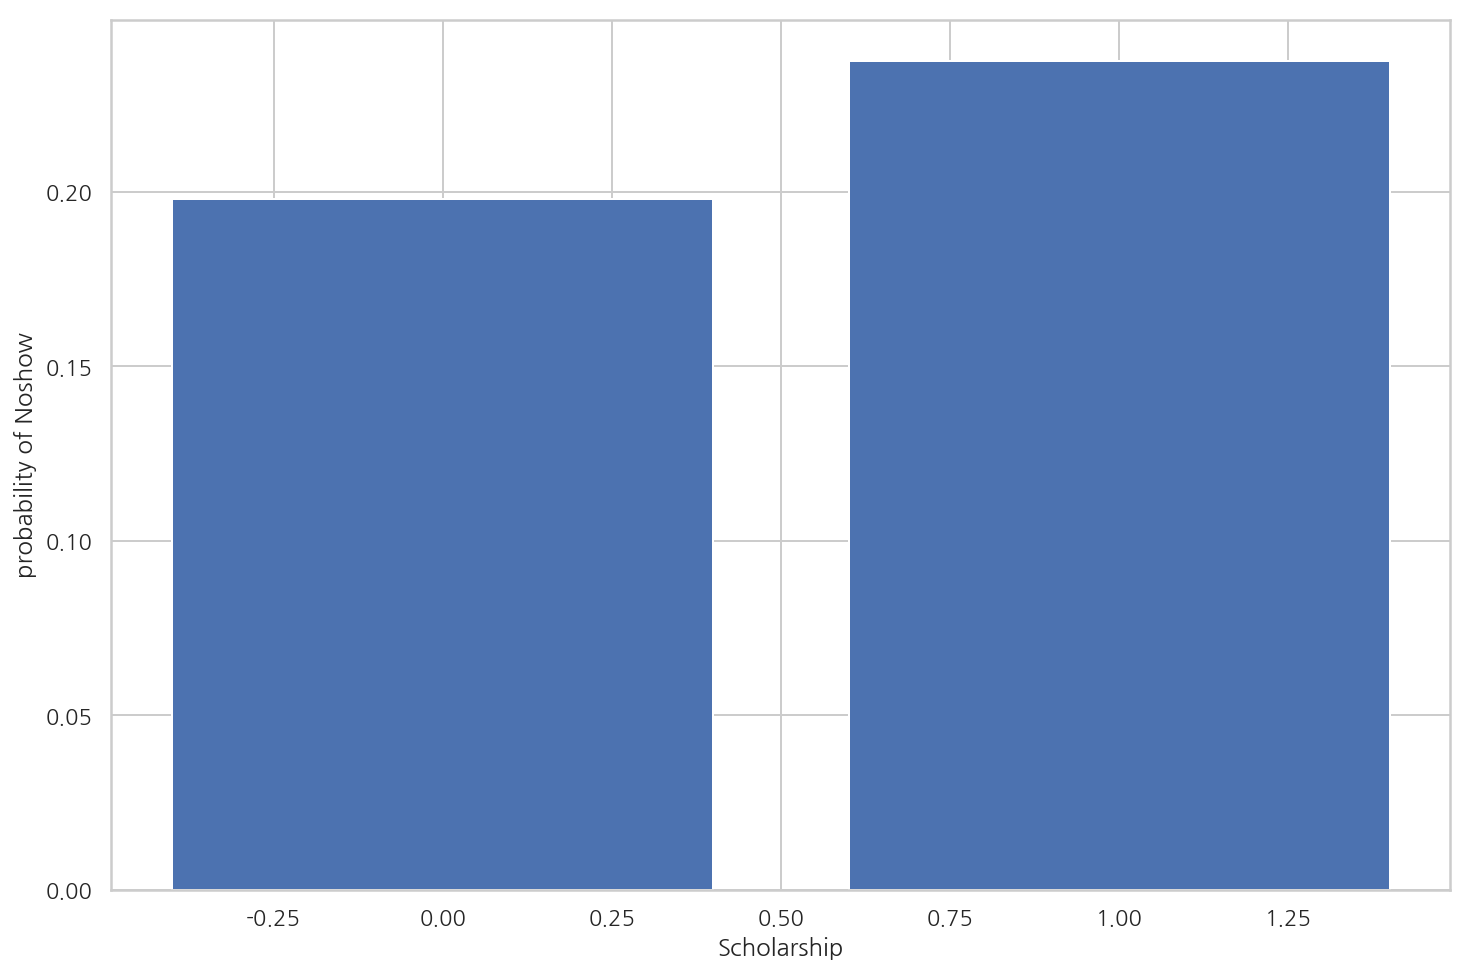

In [91]:
plt.figure(figsize=(12,8))
plt.xlabel("Scholarship")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Scholarship")["Scholarship"].values), height=cal_probNoshow(df, "Scholarship")["probNoshow"], width=0.8)
plt.show()

### Hipertension
- 고혈압을 앓고 있지 않는 환자가 더 많음을 확인 할 수 있다.

In [92]:
df.groupby("Hipertension").size()

Hipertension
0    88720
1    21801
dtype: int64

각각 예약 진료 방문여부에 대해 count를 해보면 다음과 같다.

In [93]:
df.groupby(["Hipertension","No-show"]).size()

Hipertension  No-show
0             No         70178
              Yes        18542
1             No         18029
              Yes         3772
dtype: int64

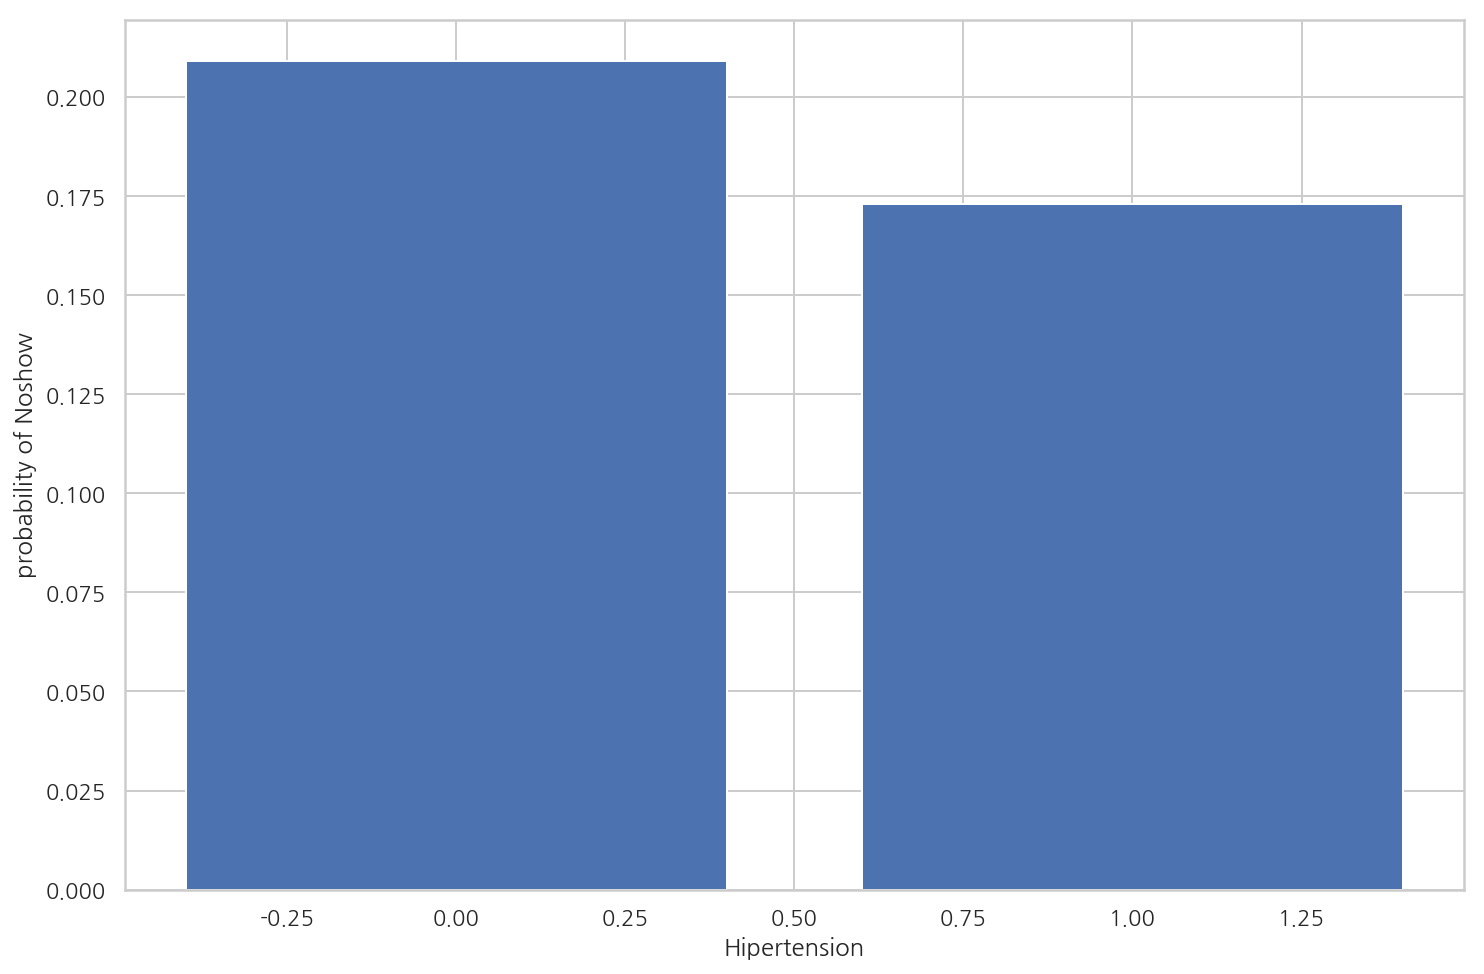

In [94]:
plt.figure(figsize=(12,8))
plt.xlabel("Hipertension")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Hipertension")["Hipertension"].values), height=cal_probNoshow(df, "Hipertension")["probNoshow"], width=0.8)
plt.show()

### Diabetes
- 당뇨병이 없는 환자가 더 많음을 확인 할 수 있다.

In [95]:
df.groupby("Diabetes").size()

Diabetes
0    102578
1      7943
dtype: int64

각각 예약 진료 방문여부에 대해 count를 해보면 다음과 같다.

In [96]:
df.groupby(["Diabetes","No-show"]).size()

Diabetes  No-show
0         No         81694
          Yes        20884
1         No          6513
          Yes         1430
dtype: int64

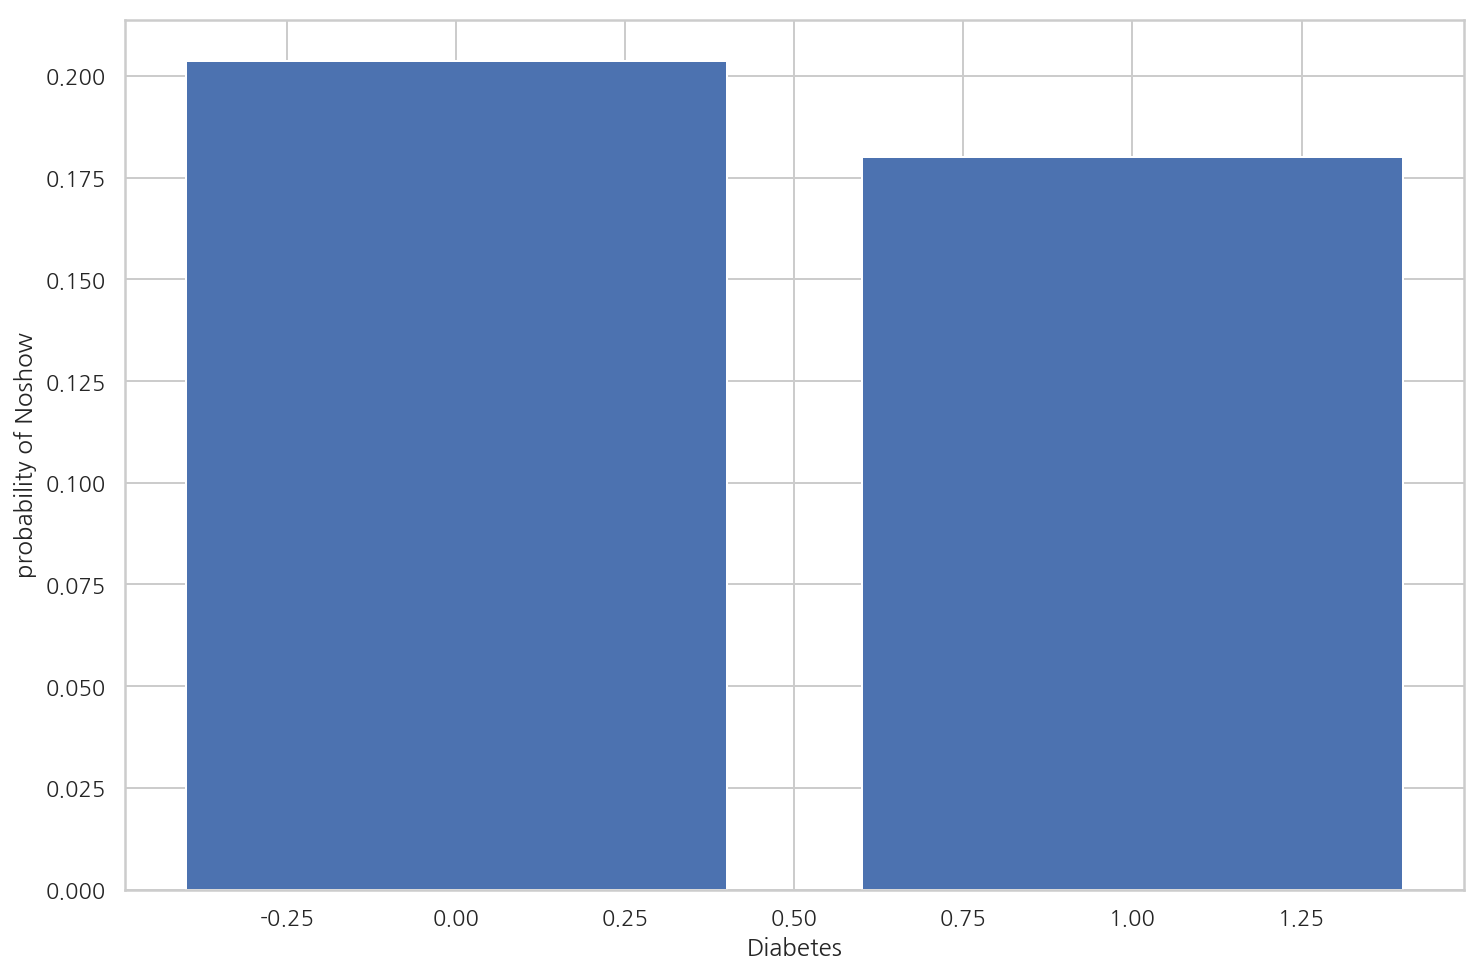

In [97]:
plt.figure(figsize=(12,8))
plt.xlabel("Diabetes")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Diabetes")["Diabetes"].values), height=cal_probNoshow(df, "Diabetes")["probNoshow"], width=0.8)
plt.show()

### Alcoholism
- 알코올 중독 여부를 의미한다.

In [98]:
df.groupby("Alcoholism").size()

Alcoholism
0    107161
1      3360
dtype: int64

각각 예약 진료 방문여부에 대해 count를 해보면 다음과 같다.

In [99]:
df.groupby(["Alcoholism","No-show"]).size()

Alcoholism  No-show
0           No         85524
            Yes        21637
1           No          2683
            Yes          677
dtype: int64

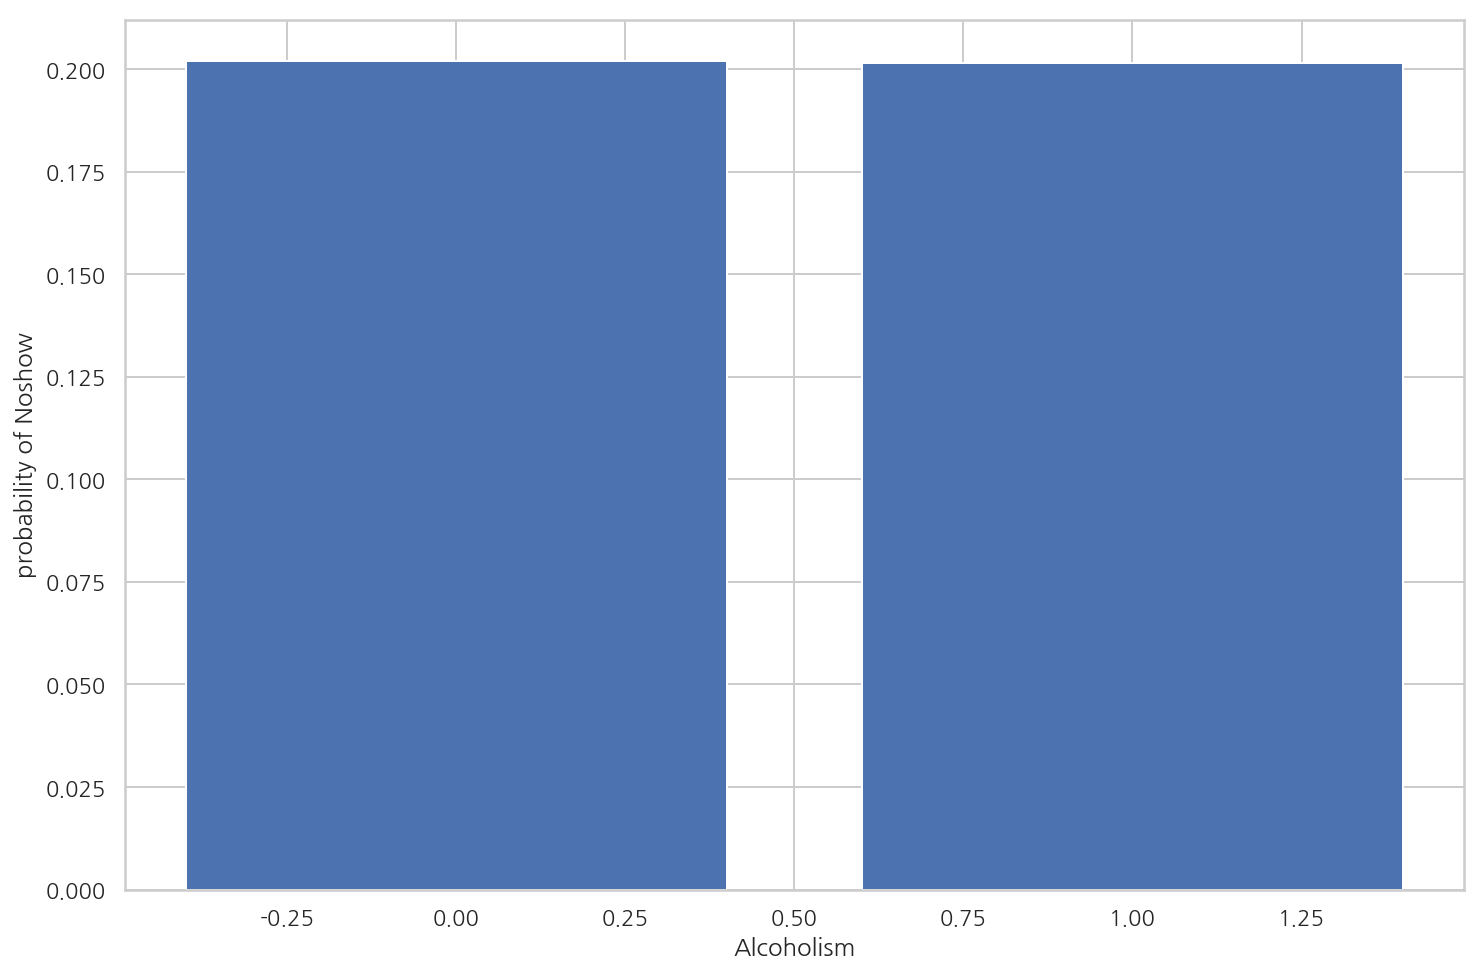

In [100]:
plt.figure(figsize=(12,8))
plt.xlabel("Alcoholism")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Alcoholism")["Alcoholism"].values), height=cal_probNoshow(df, "Alcoholism")["probNoshow"], width=0.8)
plt.show()

### Handcap

In [101]:
df.groupby("Handcap").size()

Handcap
0    108282
1      2040
2       183
3        13
4         3
dtype: int64

각각 예약 진료 방문여부에 대해 count를 해보면 다음과 같다.

In [102]:
df.groupby(["Handcap","No-show"]).size()

Handcap  No-show
0        No         86373
         Yes        21909
1        No          1676
         Yes          364
2        No           146
         Yes           37
3        No            10
         Yes            3
4        No             2
         Yes            1
dtype: int64

In [103]:
df.groupby(["Handcap","Scholarship"]).size()

Handcap  Scholarship
0        0              97599
         1              10683
1        0               1880
         1                160
2        0                165
         1                 18
3        0                 13
4        0                  3
dtype: int64

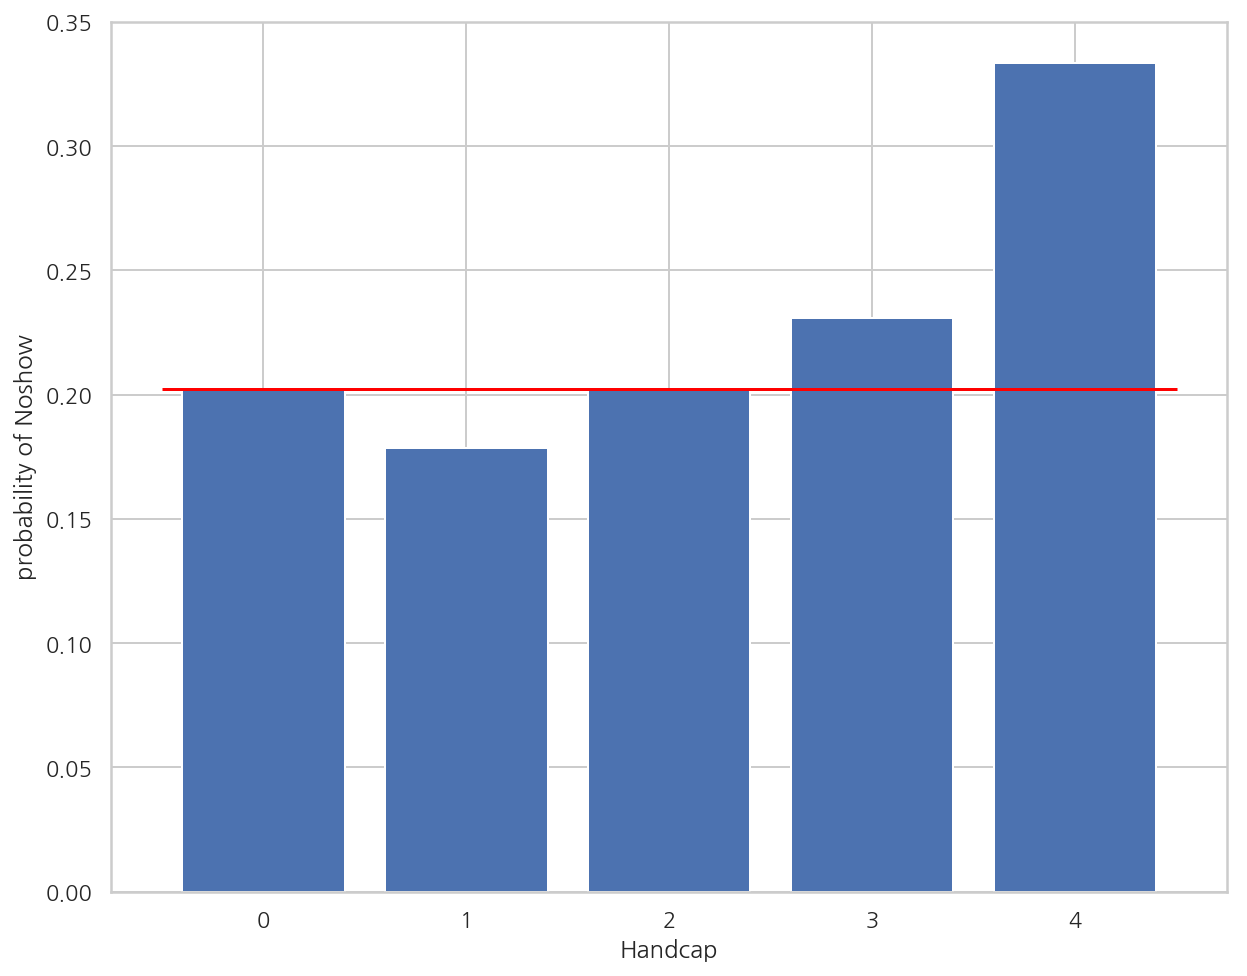

In [104]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.xlabel("Handcap")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "Handcap")["Handcap"].values), height=cal_probNoshow(df, "Handcap")["probNoshow"], width=0.8)
ax.hlines(np.median(cal_probNoshow(df, "Handcap")["probNoshow"]),-0.5,4.5,color="red")
plt.show()

### SMS_received

진료 예약 문자를 받은 환자를 의미함.

In [108]:
df.groupby("SMS_received").size()

SMS_received
0    75039
1    35482
dtype: int64

각각 예약 진료 방문여부에 대해 count를 해보면 다음과 같다.

오히려 문자를 안받은 환자들이 더 많이 재방문을 한다고 할 수 있다.

In [109]:
df.groupby(["SMS_received","No-show"]).size()

SMS_received  No-show
0             No         62509
              Yes        12530
1             No         25698
              Yes         9784
dtype: int64

In [110]:
df.groupby(["Neighbourhood","SMS_received"]).size()

Neighbourhood        SMS_received
AEROPORTO            0                  7
                     1                  1
ANDORINHAS           0               1695
                     1                567
ANTÔNIO HONÓRIO      0                178
                     1                 93
ARIOVALDO FAVALESSA  0                225
                     1                 57
BARRO VERMELHO       0                280
                     1                143
BELA VISTA           0               1330
                     1                577
BENTO FERREIRA       0                535
                     1                323
BOA VISTA            0                187
                     1                125
BONFIM               0               1994
                     1                779
CARATOÍRA            0               2033
                     1                532
CENTRO               0               2254
                     1               1080
COMDUSA              0                201


<Figure size 864x576 with 0 Axes>

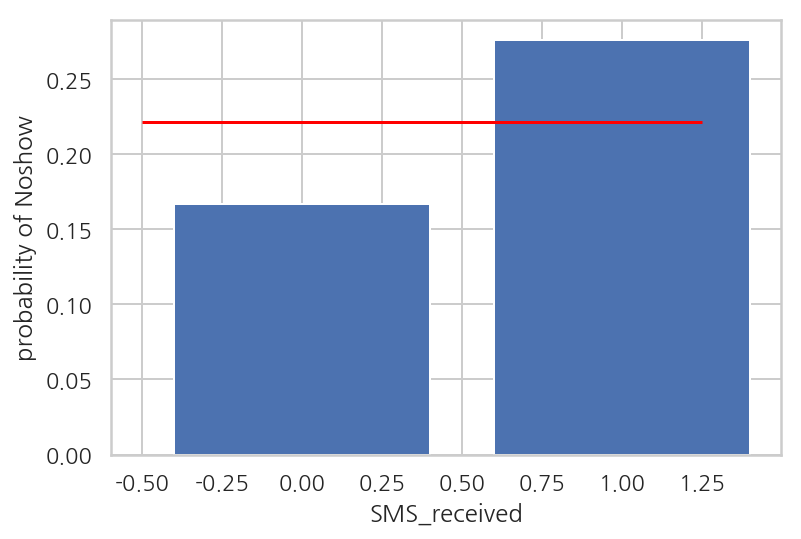

In [111]:
plt.figure(figsize=(12,8))
fig, ax = plt.subplots()
plt.xlabel("SMS_received")
plt.ylabel("probability of Noshow")
plt.bar(x=list(cal_probNoshow(df, "SMS_received")["SMS_received"].values), height=cal_probNoshow(df, "SMS_received")["probNoshow"], width=0.8)
ax.hlines(np.mean(cal_probNoshow(df, "SMS_received")["probNoshow"]),-0.5,1.25,color="red")
plt.show()

In [112]:
sum(df[df.differ_day<3].SMS_received)

0

In [113]:
df["within_2days"]=df.differ_day.apply(lambda x : 1 if x < 3 else 0)

### appointmentId를 scheduledDay대신 사용 시간의 흐름을 나타내기 위해 PatientId는 지역과 그 사람의 정보를 나타내는 것이기 때문에 지역정보인 Neighbourhood를 사용할 것. appoint_Year는 2016년만 있으므로 제거.

사용하는 변수들 : 'Gender', 'differ_day', 'Age_group', 'appoint_dayofweek', Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'

제거해줄 변수들 : 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Age', 'scheduled_Year', 'scheduled_day', 'scheduled_Hour', 'scheduled_dayofweek', 'appoint_Year', 'appoint_day'

위의 변수들을 제거해준다.

In [114]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Year', 'scheduled_month', 'scheduled_day',
       'scheduled_Hour', 'scheduled_dayofweek', 'appoint_Year',
       'appoint_month', 'appoint_day', 'appoint_dayofweek', 'total_visit_num',
       'differ_day', 'within_2days'],
      dtype='object')

In [115]:
df=df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'scheduled_Year', 'scheduled_month', 'appoint_month',\
                 'scheduled_day', 'Alcoholism', 'appoint_dayofweek','appoint_Year', 'appoint_day'])

In [116]:
df.columns

Index(['Gender', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Hour', 'scheduled_dayofweek',
       'total_visit_num', 'differ_day', 'within_2days'],
      dtype='object')

In [117]:
region_weather = pd.read_csv("region_weather.csv")
region_weather.tail()

,region,temperature,time,weather
2171,CENTRO,14.905556,1.462493e+09,Clear
2172,SÃO BENEDITO,28.127778,1.465258e+09,Humid
2173,ITARARÉ,11.816667,1.465258e+09,Mostly Cloudy
2174,SANTA CLARA,9.900000,1.465258e+09,Partly Cloudy
2175,CENTRO,9.955556,1.465258e+09,Partly Cloudy


In [118]:
import time
region_weather.time = region_weather.time.apply(lambda x: time.strftime("%Y-%m-%d", time.localtime(int(x))))

In [119]:
region_weather.time = pd.to_datetime(region_weather.time)

In [120]:
df = pd.merge(df, region_weather, how="inner", left_on=["Neighbourhood", "AppointmentDay"], right_on=["region", "time"])

In [121]:
df.columns

Index(['Gender', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Hour', 'scheduled_dayofweek',
       'total_visit_num', 'differ_day', 'within_2days', 'region',
       'temperature', 'time', 'weather'],
      dtype='object')

In [122]:
df=df.drop(columns=['time','region'])

## 지금 범주로 나누어주어야할 것들 

- 'Neighbourhood', 'Handcap', 'scheduled_Year', 'scheduled_month', 'scheduled_Hour', 'appoint_month', 'scheduled_dayofweek', 'appoint_dayofweek', 'Age_group'



사용하지 않을 컬럼을 제거해줌.

In [123]:
df.columns

Index(['Gender', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hipertension', 'Diabetes', 'Handcap', 'SMS_received', 'No-show',
       'probNoshow', 'scheduled_Hour', 'scheduled_dayofweek',
       'total_visit_num', 'differ_day', 'within_2days', 'temperature',
       'weather'],
      dtype='object')

In [129]:
df["during_first_visit"]=df.total_visit_num.apply(lambda x : 1 if x == 1 else 0)

In [130]:
non_categorical_col=["differ_day", "Age", "temperature", "probNoshow", "total_visit_num","No-show"]

In [131]:
categorical_col = list(set(df.columns)-set(non_categorical_col))
categorical_col

['within_2days',
 'scheduled_Hour',
 'scheduled_dayofweek',
 'Hipertension',
 'Neighbourhood',
 'Scholarship',
 'SMS_received',
 'weather',
 'Diabetes',
 'Gender',
 'AppointmentDay',
 'Handcap',
 'during_first_visit']

In [132]:
dfX=df[["differ_day", "Age", "temperature", "total_visit_num", "probNoshow"]]

In [133]:
dfX2=pd.get_dummies(df[categorical_col].astype(str), drop_first=True)

In [134]:
dfX=pd.concat((dfX,dfX2),axis=1)
dfy=df["No-show"]

In [135]:
dfX.columns

Index(['differ_day', 'Age', 'temperature', 'total_visit_num', 'probNoshow',
       'within_2days_1', 'scheduled_Hour_11', 'scheduled_Hour_12',
       'scheduled_Hour_13', 'scheduled_Hour_14',
       ...
       'AppointmentDay_2016-06-02', 'AppointmentDay_2016-06-03',
       'AppointmentDay_2016-06-06', 'AppointmentDay_2016-06-07',
       'AppointmentDay_2016-06-08', 'Handcap_1', 'Handcap_2', 'Handcap_3',
       'Handcap_4', 'during_first_visit_1'],
      dtype='object', length=153)

In [136]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(dfX, dfy)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

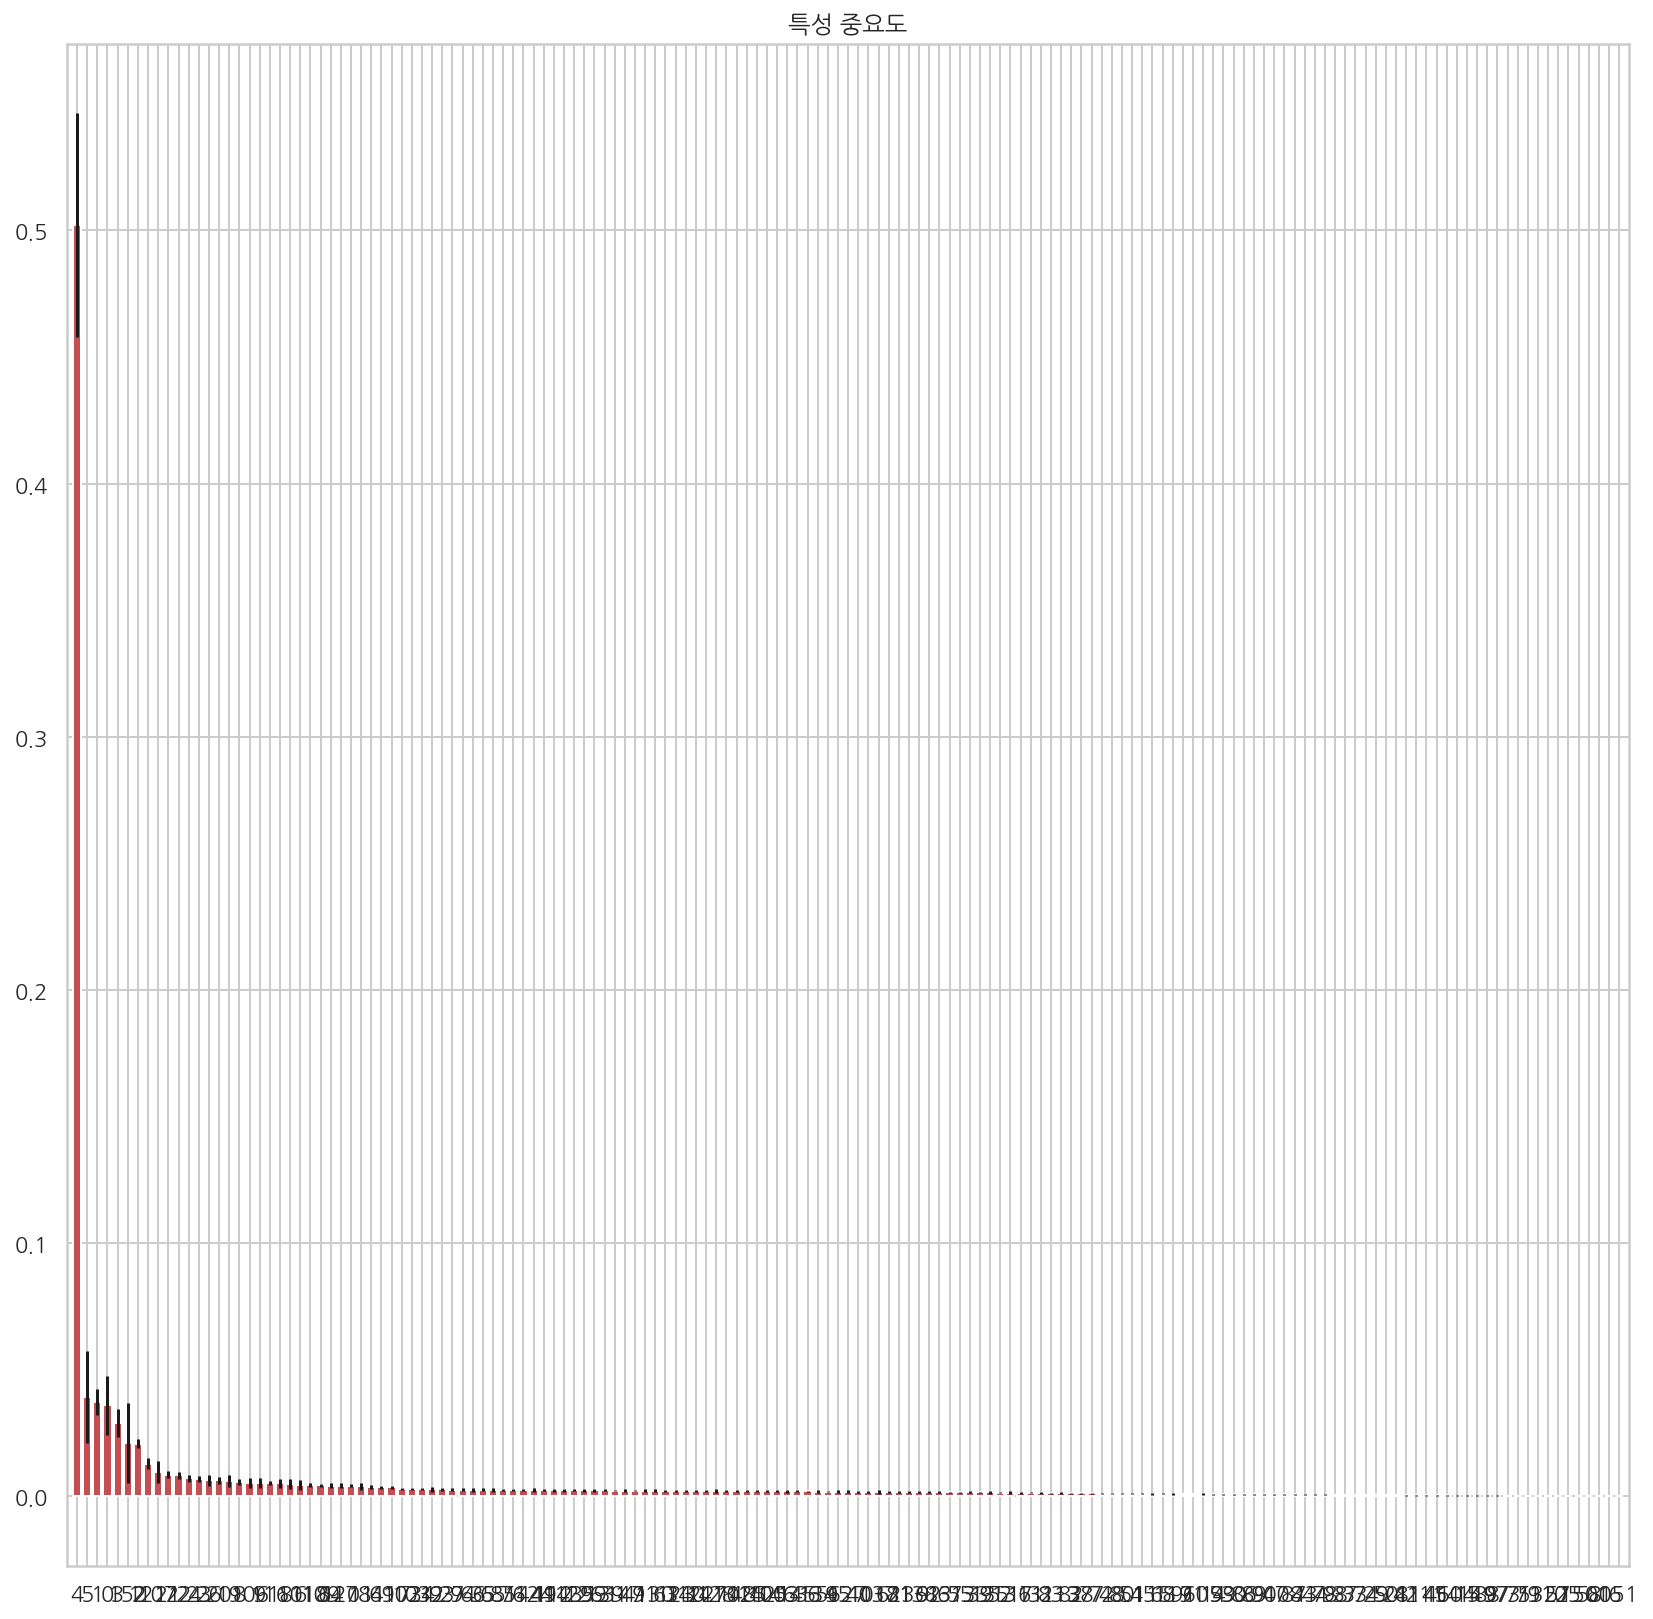

In [137]:
plt.figure(figsize=(14,14))
plt.title("특성 중요도")
plt.bar(range(dfX.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(dfX.shape[1]), indices)
plt.xlim([-1, dfX.shape[1]])
plt.show()

In [138]:
importancetable=pd.concat((pd.DataFrame(dfX.columns[indices],columns=["features"]), pd.DataFrame(importances[indices],columns=["importance"])),axis=1)
importancetable.head(20)


,features,importance
0,probNoshow,0.502126
1,within_2days_1,0.039270
2,Age,0.037380
3,differ_day,0.035924
4,total_visit_num,0.028958
5,during_first_visit_1,0.021117
6,temperature,0.020868
7,Gender_M,0.012908
8,SMS_received_1,0.009605
9,scheduled_dayofweek_1,0.008481


In [141]:
dfX=dfX.drop(columns=["total_visit_num"])

In [142]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(dfX, dfy)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

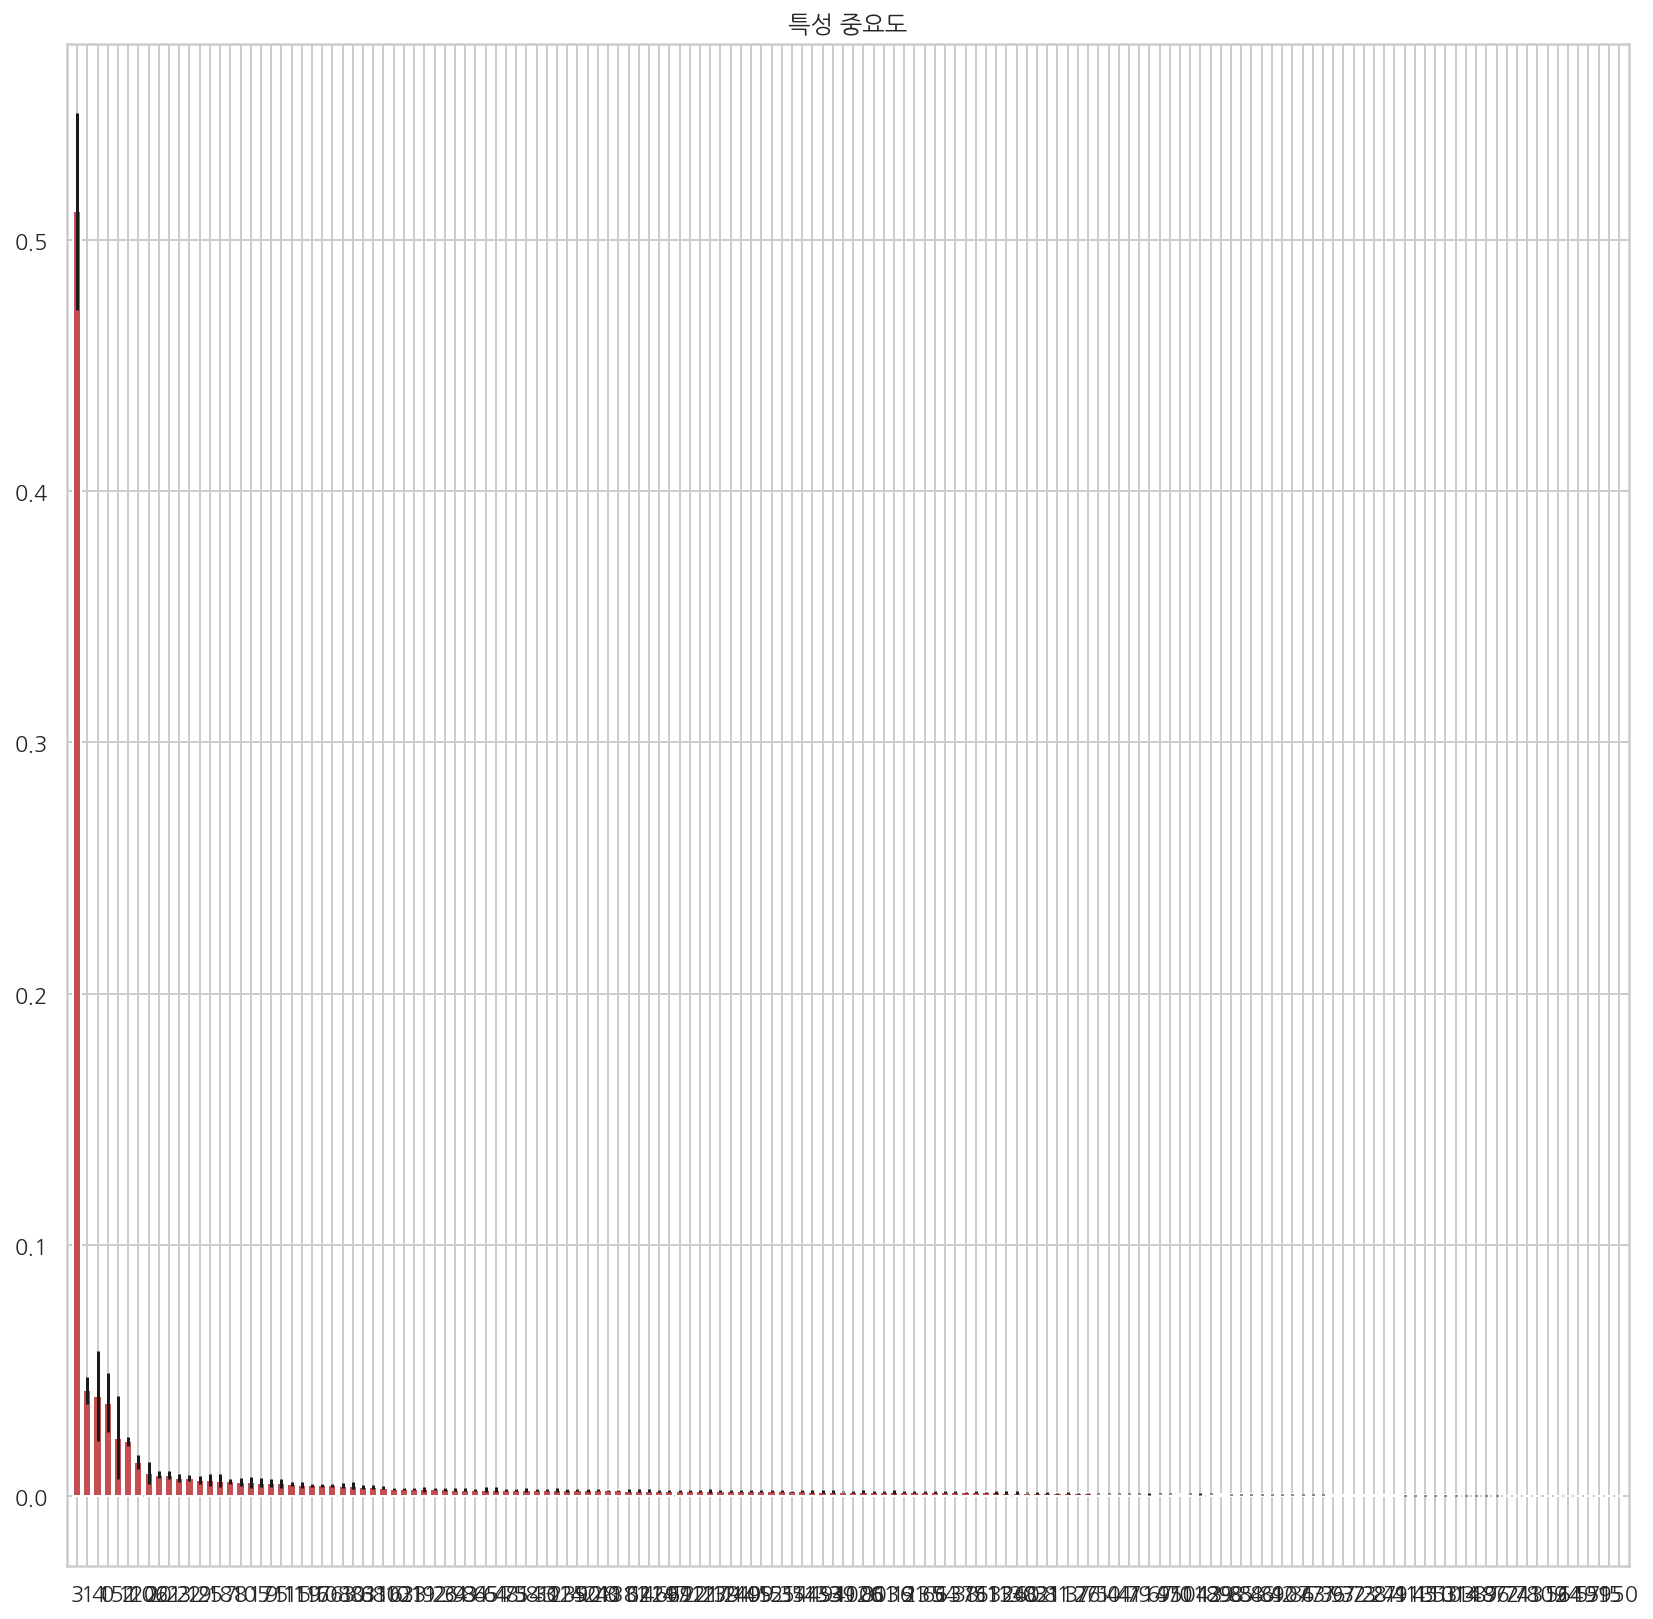

In [143]:
plt.figure(figsize=(14,14))
plt.title("특성 중요도")
plt.bar(range(dfX.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(dfX.shape[1]), indices)
plt.xlim([-1, dfX.shape[1]])
plt.show()

In [144]:
importancetable=pd.concat((pd.DataFrame(dfX.columns[indices],columns=["features"]), pd.DataFrame(importances[indices],columns=["importance"])),axis=1)
importancetable.head(20)


,features,importance
0,probNoshow,0.511299
1,Age,0.042273
2,within_2days_1,0.039977
3,differ_day,0.037323
4,during_first_visit_1,0.023419
5,temperature,0.021880
6,Gender_M,0.013737
7,SMS_received_1,0.009441
8,scheduled_dayofweek_1,0.008698
9,scheduled_dayofweek_2,0.008589


In [145]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0)

In [146]:
sum(y_train=="No")/sum(y_train=="Yes")

3.9295272078501338

In [147]:
sum(y_test=="No")/sum(y_test=="Yes")

4.008459214501511

In [148]:
X_train.columns

Index(['differ_day', 'Age', 'temperature', 'probNoshow', 'within_2days_1',
       'scheduled_Hour_11', 'scheduled_Hour_12', 'scheduled_Hour_13',
       'scheduled_Hour_14', 'scheduled_Hour_15',
       ...
       'AppointmentDay_2016-06-02', 'AppointmentDay_2016-06-03',
       'AppointmentDay_2016-06-06', 'AppointmentDay_2016-06-07',
       'AppointmentDay_2016-06-08', 'Handcap_1', 'Handcap_2', 'Handcap_3',
       'Handcap_4', 'during_first_visit_1'],
      dtype='object', length=152)

In [149]:
%%time
model_svc = SVC().fit(X_train, y_train)

CPU times: user 9min 31s, sys: 1.56 s, total: 9min 32s
Wall time: 9min 35s


In [ ]:
%%time
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = model_svc.predict(X_train)
y_pred_test = model_svc.predict(X_test)

In [161]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     61801
         Yes       0.76      0.00      0.00     15563

   micro avg       0.80      0.80      0.80     77364
   macro avg       0.78      0.50      0.45     77364
weighted avg       0.79      0.80      0.71     77364



In [162]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     26405
         Yes       0.62      0.00      0.00      6751

   micro avg       0.80      0.80      0.80     33156
   macro avg       0.71      0.50      0.44     33156
weighted avg       0.76      0.80      0.71     33156



## RandomUnderSampler

In [164]:
X_rand_samp, y_rand_samp = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

In [171]:
len(X_train)

77364

In [170]:
len(X_rand_samp)

31126

In [166]:
%%time
model_svc_randomunder = SVC().fit(X_rand_samp, y_rand_samp)

CPU times: user 2min 44s, sys: 350 ms, total: 2min 44s
Wall time: 2min 44s


In [167]:
%%time
y_pred_train0 = model_svc_randomunder.predict(X_train)
y_pred_test0 = model_svc_randomunder.predict(X_test)

CPU times: user 5min 31s, sys: 1.05 s, total: 5min 32s
Wall time: 5min 34s


In [180]:
confusion_matrix(y_test, y_pred_test0, labels=["Yes", "No"])

array([[ 5392,  1359],
       [11854, 14551]])

In [168]:
print(classification_report(y_train, y_pred_train0))

              precision    recall  f1-score   support

          No       0.91      0.55      0.68     61801
         Yes       0.31      0.79      0.44     15563

   micro avg       0.60      0.60      0.60     77364
   macro avg       0.61      0.67      0.56     77364
weighted avg       0.79      0.60      0.64     77364



In [169]:
print(classification_report(y_test, y_pred_test0))

              precision    recall  f1-score   support

          No       0.91      0.55      0.69     26405
         Yes       0.31      0.80      0.45      6751

   micro avg       0.60      0.60      0.60     33156
   macro avg       0.61      0.67      0.57     33156
weighted avg       0.79      0.60      0.64     33156



In [184]:
accuracy_score(y_test, y_pred_test0)

0.6014899264084932

## Tomek’s link method

In [185]:
X_Tomek_samp, y_Tomek_samp = TomekLinks(random_state=0).fit_sample(X_train, y_train)

In [186]:
X_train.shape, X_Tomek_samp.shape

((77364, 123), (72591, 123))

In [190]:
%%time
model_svc_Tomek = SVC().fit(X_Tomek_samp, y_Tomek_samp)

CPU times: user 38min 46s, sys: 7.2 s, total: 38min 53s
Wall time: 39min 2s


In [191]:
%%time
y_pred_train2 = model_svc_Tomek.predict(X_train)
y_pred_test2 = model_svc_Tomek.predict(X_test)

CPU times: user 9min, sys: 832 ms, total: 9min
Wall time: 9min 2s


In [197]:
confusion_matrix(y_test, y_pred_test2)

array([[26365,    40],
       [ 6704,    47]])

In [198]:
print(classification_report(y_train, y_pred_train2))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     61801
         Yes       0.66      0.01      0.02     15563

   micro avg       0.80      0.80      0.80     77364
   macro avg       0.73      0.51      0.46     77364
weighted avg       0.77      0.80      0.71     77364



In [199]:
print(classification_report(y_test, y_pred_test2))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     26405
         Yes       0.54      0.01      0.01      6751

   micro avg       0.80      0.80      0.80     33156
   macro avg       0.67      0.50      0.45     33156
weighted avg       0.74      0.80      0.71     33156



In [195]:
accuracy_score(y_test, y_pred_test2)

0.7965979008324285

## SMOTEENN

In [172]:
X_SMOTEENN_samp, y_SMOTEENN_samp = SMOTEENN(random_state=0).fit_sample(X_train, y_train)

In [173]:
X_train.shape

(77364, 123)

In [175]:
X_SMOTEENN_samp.shape

(85010, 123)

In [176]:
%%time
model_svc_SMOTEENN = SVC().fit(X_SMOTEENN_samp, y_SMOTEENN_samp)

In [178]:
%%time
y_pred_train1 = model_svc_SMOTEENN.predict(X_train)
y_pred_test1 = model_svc_SMOTEENN.predict(X_test)

In [179]:
confusion_matrix(y_test, y_pred_test1, labels=["Yes", "No"])

array([[ 6204,   547],
       [15212, 11193]])

In [181]:
print(classification_report(y_train, y_pred_train1))

              precision    recall  f1-score   support

          No       0.96      0.42      0.59     61801
         Yes       0.29      0.93      0.44     15563

   micro avg       0.52      0.52      0.52     77364
   macro avg       0.62      0.67      0.51     77364
weighted avg       0.82      0.52      0.56     77364



In [182]:
print(classification_report(y_test, y_pred_test1))

              precision    recall  f1-score   support

          No       0.95      0.42      0.59     26405
         Yes       0.29      0.92      0.44      6751

   micro avg       0.52      0.52      0.52     33156
   macro avg       0.62      0.67      0.51     33156
weighted avg       0.82      0.52      0.56     33156



In [183]:
accuracy_score(y_test, y_pred_test1)

0.5247014115092291

## ENN

In [201]:
X_ENN_all_samp, y_ENN_all_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

In [202]:
X_ENN_mode_samp, y_ENN_mode_samp = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

In [203]:
X_ENN_all_samp.shape

(45544, 123)

In [204]:
X_ENN_mode_samp.shape

(72410, 123)

In [205]:
%%time
model_svc_ENN_all = SVC().fit(X_ENN_all_samp, y_ENN_all_samp)

CPU times: user 3min 54s, sys: 1.33 s, total: 3min 55s
Wall time: 1h 48min 8s


In [207]:
%%time
model_svc_ENN_mode = SVC().fit(X_ENN_mode_samp, y_ENN_mode_samp)

CPU times: user 31min 45s, sys: 4.79 s, total: 31min 50s
Wall time: 2h 4min 7s


In [208]:
%%time
y_pred_train3 = model_svc_ENN_all.predict(X_train)
y_pred_test3 = model_svc_ENN_all.predict(X_test)

CPU times: user 4min 51s, sys: 902 ms, total: 4min 52s
Wall time: 4min 53s


In [209]:
%%time
y_pred_train4 = model_svc_ENN_mode.predict(X_train)
y_pred_test4 = model_svc_ENN_mode.predict(X_test)

CPU times: user 8min 50s, sys: 711 ms, total: 8min 51s
Wall time: 24min 14s


In [210]:
confusion_matrix(y_test, y_pred_test3, labels=["Yes", "No"])

array([[ 4745,  2006],
       [ 9712, 16693]])

In [211]:
print(classification_report(y_train, y_pred_train3))

              precision    recall  f1-score   support

          No       0.90      0.63      0.74     61801
         Yes       0.32      0.71      0.45     15563

   micro avg       0.64      0.64      0.64     77364
   macro avg       0.61      0.67      0.59     77364
weighted avg       0.78      0.64      0.68     77364



In [212]:
print(classification_report(y_test, y_pred_test3))

              precision    recall  f1-score   support

          No       0.89      0.63      0.74     26405
         Yes       0.33      0.70      0.45      6751

   micro avg       0.65      0.65      0.65     33156
   macro avg       0.61      0.67      0.59     33156
weighted avg       0.78      0.65      0.68     33156



In [213]:
accuracy_score(y_test, y_pred_test3)

0.6465798045602605

In [214]:
confusion_matrix(y_test, y_pred_test4, labels=["Yes", "No"])

array([[  227,  6524],
       [  301, 26104]])

In [215]:
print(classification_report(y_train, y_pred_train4))

              precision    recall  f1-score   support

          No       0.80      0.99      0.89     61801
         Yes       0.52      0.04      0.08     15563

   micro avg       0.80      0.80      0.80     77364
   macro avg       0.66      0.52      0.48     77364
weighted avg       0.75      0.80      0.73     77364



In [216]:
print(classification_report(y_test, y_pred_test4))

              precision    recall  f1-score   support

          No       0.80      0.99      0.88     26405
         Yes       0.43      0.03      0.06      6751

   micro avg       0.79      0.79      0.79     33156
   macro avg       0.61      0.51      0.47     33156
weighted avg       0.72      0.79      0.72     33156



In [217]:
accuracy_score(y_test, y_pred_test4)

0.7941549040897575

## Age와 differ_day의 countour plot 그려보기 

In [127]:
df.columns

Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Handcap', 'SMS_received', 'No-show', 'scheduled_Hour',
       'scheduled_dayofweek', 'differ_day', 'temperature', 'weather',
       'latitude', 'longitude'],
      dtype='object')

In [128]:
df=df.drop(columns=["Neighbourhood"])

In [129]:
non_categorical_col=["differ_day","No-show","Age","temperature", "latitude", "longitude"]

In [130]:
categorical_col = list(set(df.columns)-set(non_categorical_col))
categorical_col

['Diabetes',
 'weather',
 'Gender',
 'SMS_received',
 'Hipertension',
 'scheduled_Hour',
 'Handcap',
 'Scholarship',
 'scheduled_dayofweek']

In [131]:
dfX=df[["differ_day","Age","temperature", "latitude", "longitude"]]

In [132]:
dfX2=pd.get_dummies(df[categorical_col].astype(str), drop_first=True)

In [133]:
dfX=pd.concat((dfX,dfX2),axis=1)
dfy=df["No-show"]

In [134]:
dfX.columns

Index(['differ_day', 'Age', 'temperature', 'latitude', 'longitude',
       'Diabetes_1', 'weather_Breezy and Overcast', 'weather_Clear',
       'weather_Drizzle', 'weather_Foggy', 'weather_Humid',
       'weather_Humid and Mostly Cloudy', 'weather_Humid and Partly Cloudy',
       'weather_Light Rain and Breezy', 'weather_Mostly Cloudy',
       'weather_Overcast', 'weather_Partly Cloudy',
       'weather_Windy and Overcast', 'Gender_M', 'SMS_received_1',
       'Hipertension_1', 'scheduled_Hour_11', 'scheduled_Hour_12',
       'scheduled_Hour_13', 'scheduled_Hour_14', 'scheduled_Hour_15',
       'scheduled_Hour_16', 'scheduled_Hour_17', 'scheduled_Hour_18',
       'scheduled_Hour_19', 'scheduled_Hour_20', 'scheduled_Hour_21',
       'scheduled_Hour_6', 'scheduled_Hour_7', 'scheduled_Hour_8',
       'scheduled_Hour_9', 'Handcap_1', 'Handcap_2', 'Handcap_3', 'Handcap_4',
       'Scholarship_1', 'scheduled_dayofweek_1', 'scheduled_dayofweek_2',
       'scheduled_dayofweek_3', 'scheduled_da

In [135]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(dfX, dfy)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

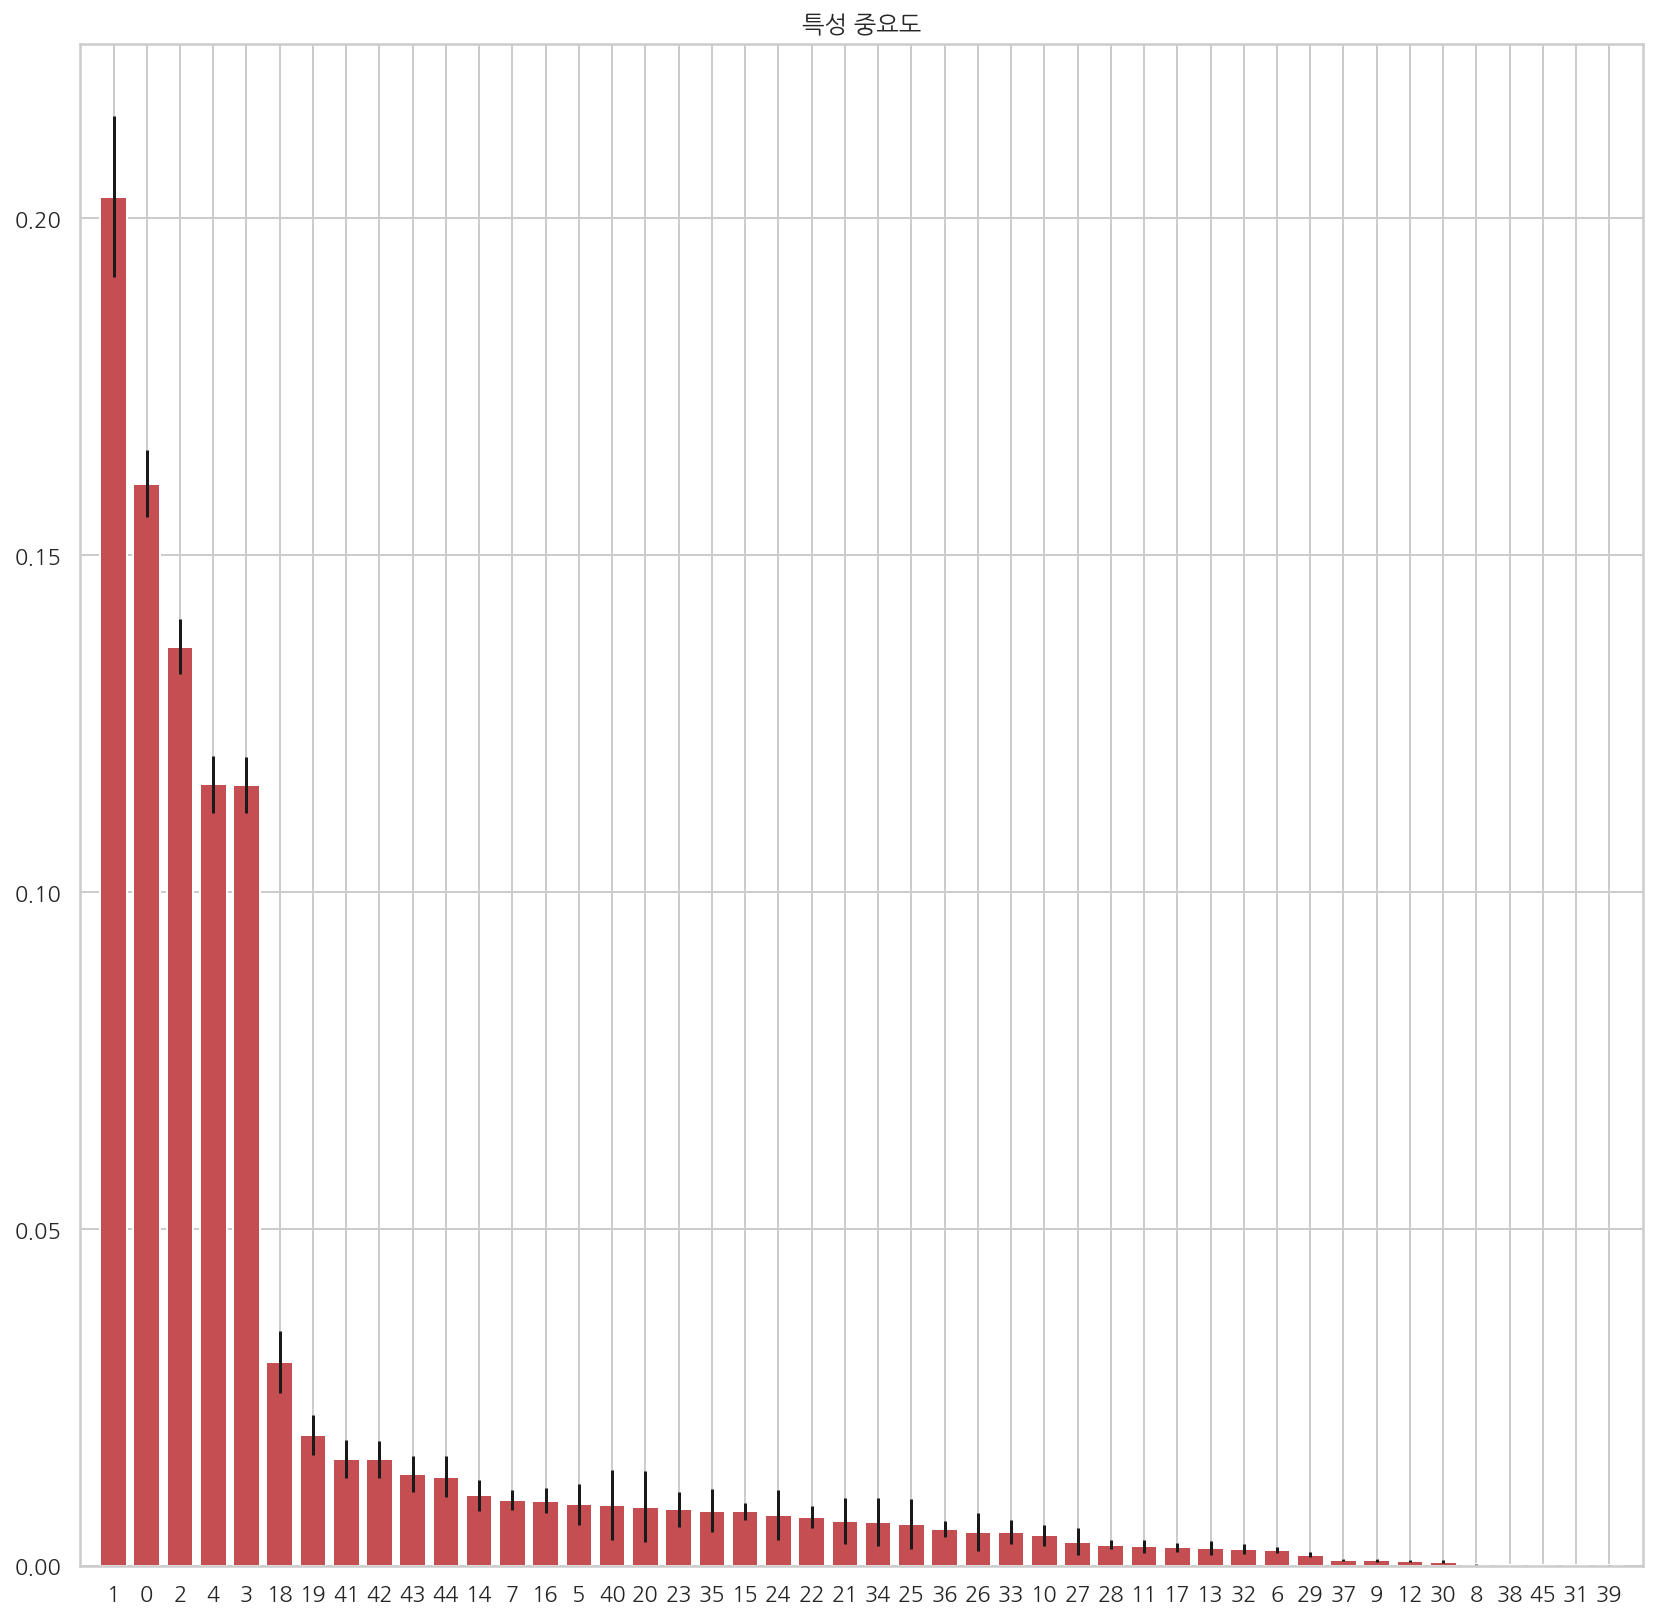

In [136]:
plt.figure(figsize=(14,14))
plt.title("특성 중요도")
plt.bar(range(dfX.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(dfX.shape[1]), indices)
plt.xlim([-1, dfX.shape[1]])
plt.show()

In [137]:
importancetable=pd.concat((pd.DataFrame(dfX.columns[indices],columns=["features"]), pd.DataFrame(importances[indices],columns=["importance"])),axis=1)
importancetable.head(20)


,features,importance
0,Age,0.203231
1,differ_day,0.160596
2,temperature,0.136395
3,longitude,0.115976
4,latitude,0.115921
5,Gender_M,0.030161
6,SMS_received_1,0.019435
7,scheduled_dayofweek_1,0.015845
8,scheduled_dayofweek_2,0.015802
9,scheduled_dayofweek_3,0.013563


In [138]:
df.columns

Index(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Handcap',
       'SMS_received', 'No-show', 'scheduled_Hour', 'scheduled_dayofweek',
       'differ_day', 'temperature', 'weather', 'latitude', 'longitude'],
      dtype='object')

In [139]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.3, random_state=0)

In [140]:
sum(y_train=="No")/sum(y_train=="Yes")

3.9646409548867356

In [141]:
sum(y_test=="No")/sum(y_test=="Yes")

3.925865398900609

In [142]:
X_train.columns

Index(['differ_day', 'Age', 'temperature', 'latitude', 'longitude',
       'Diabetes_1', 'weather_Breezy and Overcast', 'weather_Clear',
       'weather_Drizzle', 'weather_Foggy', 'weather_Humid',
       'weather_Humid and Mostly Cloudy', 'weather_Humid and Partly Cloudy',
       'weather_Light Rain and Breezy', 'weather_Mostly Cloudy',
       'weather_Overcast', 'weather_Partly Cloudy',
       'weather_Windy and Overcast', 'Gender_M', 'SMS_received_1',
       'Hipertension_1', 'scheduled_Hour_11', 'scheduled_Hour_12',
       'scheduled_Hour_13', 'scheduled_Hour_14', 'scheduled_Hour_15',
       'scheduled_Hour_16', 'scheduled_Hour_17', 'scheduled_Hour_18',
       'scheduled_Hour_19', 'scheduled_Hour_20', 'scheduled_Hour_21',
       'scheduled_Hour_6', 'scheduled_Hour_7', 'scheduled_Hour_8',
       'scheduled_Hour_9', 'Handcap_1', 'Handcap_2', 'Handcap_3', 'Handcap_4',
       'Scholarship_1', 'scheduled_dayofweek_1', 'scheduled_dayofweek_2',
       'scheduled_dayofweek_3', 'scheduled_da

In [138]:
%%time
model_svc = SVC().fit(X_train, y_train)

CPU times: user 29min 12s, sys: 7.21 s, total: 29min 19s
Wall time: 1h 46min 42s


In [139]:
%%time
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = model_svc.predict(X_train)
y_pred_test = model_svc.predict(X_test)

CPU times: user 3min 42s, sys: 1.68 s, total: 3min 44s
Wall time: 3min 48s


In [140]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     61781
         Yes       0.80      0.03      0.05     15583

   micro avg       0.80      0.80      0.80     77364
   macro avg       0.80      0.51      0.47     77364
weighted avg       0.80      0.80      0.72     77364



In [141]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          No       0.80      1.00      0.89     26425
         Yes       0.54      0.02      0.03      6731

   micro avg       0.80      0.80      0.80     33156
   macro avg       0.67      0.51      0.46     33156
weighted avg       0.75      0.80      0.71     33156



## RandomUnderSampler

In [142]:
X_rand_samp, y_rand_samp = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

In [143]:
len(X_train)

77364

In [144]:
len(X_rand_samp)

31166

In [145]:
%%time
model_svc_randomunder = SVC().fit(X_rand_samp, y_rand_samp)

CPU times: user 1min 30s, sys: 834 ms, total: 1min 31s
Wall time: 1min 32s


In [146]:
%%time
y_pred_train0 = model_svc_randomunder.predict(X_train)
y_pred_test0 = model_svc_randomunder.predict(X_test)

CPU times: user 2min 8s, sys: 933 ms, total: 2min 9s
Wall time: 2min 10s


In [152]:
confusion_matrix(y_test, y_pred_test0, labels=["Yes", "No"])

array([[ 5241,  1490],
       [11785, 14640]])

In [153]:
print(classification_report(y_train, y_pred_train0))

              precision    recall  f1-score   support

          No       0.92      0.57      0.70     61781
         Yes       0.32      0.80      0.46     15583

   micro avg       0.61      0.61      0.61     77364
   macro avg       0.62      0.68      0.58     77364
weighted avg       0.80      0.61      0.65     77364



In [154]:
print(classification_report(y_test, y_pred_test0))

              precision    recall  f1-score   support

          No       0.91      0.55      0.69     26425
         Yes       0.31      0.78      0.44      6731

   micro avg       0.60      0.60      0.60     33156
   macro avg       0.61      0.67      0.56     33156
weighted avg       0.79      0.60      0.64     33156



In [155]:
accuracy_score(y_test, y_pred_test0)

0.5996199782844734

## ENN

In [156]:
X_ENN_all_samp, y_ENN_all_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

In [157]:
X_ENN_mode_samp, y_ENN_mode_samp = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

In [158]:
X_ENN_all_samp.shape

(45248, 46)

In [159]:
X_ENN_mode_samp.shape

(72330, 46)

In [179]:
y_ENN_all_samp

array(['No', 'No', 'No', ..., 'Yes', 'Yes', 'Yes'], dtype=object)

In [180]:
sum(y_ENN_all_samp=="No")/sum(y_ENN_all_samp=="Yes")

1.903677084001797

In [160]:
%%time
model_svc_ENN_all = SVC().fit(X_ENN_all_samp, y_ENN_all_samp)

CPU times: user 1min 58s, sys: 1.2 s, total: 1min 59s
Wall time: 2min 1s


In [161]:
%%time
model_svc_ENN_mode = SVC().fit(X_ENN_mode_samp, y_ENN_mode_samp)

CPU times: user 14min 31s, sys: 5.34 s, total: 14min 36s
Wall time: 14min 45s


In [164]:
%%time
y_pred_train3 = model_svc_ENN_all.predict(X_train)
y_pred_test3 = model_svc_ENN_all.predict(X_test)

CPU times: user 1min 52s, sys: 1.2 s, total: 1min 53s
Wall time: 1min 58s


In [165]:
%%time
y_pred_train4 = model_svc_ENN_mode.predict(X_train)
y_pred_test4 = model_svc_ENN_mode.predict(X_test)

CPU times: user 3min 28s, sys: 1.74 s, total: 3min 29s
Wall time: 3min 35s


In [166]:
confusion_matrix(y_test, y_pred_test3, labels=["Yes", "No"])

array([[ 4965,  1766],
       [10753, 15672]])

In [169]:
print(classification_report(y_train, y_pred_train3))

              precision    recall  f1-score   support

          No       0.91      0.61      0.73     61781
         Yes       0.33      0.77      0.46     15583

   micro avg       0.64      0.64      0.64     77364
   macro avg       0.62      0.69      0.60     77364
weighted avg       0.79      0.64      0.67     77364



In [170]:
print(classification_report(y_test, y_pred_test3))

              precision    recall  f1-score   support

          No       0.90      0.59      0.71     26425
         Yes       0.32      0.74      0.44      6731

   micro avg       0.62      0.62      0.62     33156
   macro avg       0.61      0.67      0.58     33156
weighted avg       0.78      0.62      0.66     33156



In [182]:
accuracy_score(y_test, y_pred_test3)

0.6224212812160695

In [172]:
confusion_matrix(y_test, y_pred_test4, labels=["Yes", "No"])

array([[  594,  6137],
       [  820, 25605]])

In [173]:
print(classification_report(y_train, y_pred_train4))

              precision    recall  f1-score   support

          No       0.82      0.98      0.89     61781
         Yes       0.57      0.12      0.20     15583

   micro avg       0.80      0.80      0.80     77364
   macro avg       0.69      0.55      0.55     77364
weighted avg       0.77      0.80      0.75     77364



In [174]:
print(classification_report(y_test, y_pred_test4))

              precision    recall  f1-score   support

          No       0.81      0.97      0.88     26425
         Yes       0.42      0.09      0.15      6731

   micro avg       0.79      0.79      0.79     33156
   macro avg       0.61      0.53      0.51     33156
weighted avg       0.73      0.79      0.73     33156



In [175]:
accuracy_score(y_test, y_pred_test4)

0.7901737242128122

In [187]:
sample_weight=[2 if i == "Yes" else  1 for i in list(y_ENN_all_samp)]

In [188]:
%%time
model_svc_ENN_all = SVC().fit(X_ENN_all_samp, y_ENN_all_samp, sample_weight=sample_weight)

CPU times: user 2min 35s, sys: 2.08 s, total: 2min 38s
Wall time: 2min 39s


In [189]:
%%time
y_pred_train5 = model_svc_ENN_all.predict(X_train)
y_pred_test5 = model_svc_ENN_all.predict(X_test)

CPU times: user 1min 51s, sys: 372 ms, total: 1min 52s
Wall time: 1min 52s


In [190]:
confusion_matrix(y_test, y_pred_test5, labels=["Yes", "No"])

array([[ 5824,   907],
       [13771, 12654]])

In [192]:
print(classification_report(y_train, y_pred_train5))

              precision    recall  f1-score   support

          No       0.94      0.49      0.65     61781
         Yes       0.31      0.89      0.45     15583

   micro avg       0.57      0.57      0.57     77364
   macro avg       0.63      0.69      0.55     77364
weighted avg       0.82      0.57      0.61     77364



In [191]:
print(classification_report(y_test, y_pred_test5))

              precision    recall  f1-score   support

          No       0.93      0.48      0.63     26425
         Yes       0.30      0.87      0.44      6731

   micro avg       0.56      0.56      0.56     33156
   macro avg       0.62      0.67      0.54     33156
weighted avg       0.80      0.56      0.59     33156



In [194]:
accuracy_score(y_test, y_pred_test5)

0.5573048618651224

In [199]:
X_train.columns

Index(['differ_day', 'Age', 'temperature', 'latitude', 'longitude',
       'Hipertension_1', 'Diabetes_1', 'scheduled_dayofweek_1',
       'scheduled_dayofweek_2', 'scheduled_dayofweek_3',
       'scheduled_dayofweek_4', 'scheduled_dayofweek_5', 'SMS_received_1',
       'Handcap_1', 'Handcap_2', 'Handcap_3', 'Handcap_4', 'Scholarship_1',
       'weather_Breezy and Overcast', 'weather_Clear', 'weather_Drizzle',
       'weather_Foggy', 'weather_Humid', 'weather_Humid and Mostly Cloudy',
       'weather_Humid and Partly Cloudy', 'weather_Light Rain and Breezy',
       'weather_Mostly Cloudy', 'weather_Overcast', 'weather_Partly Cloudy',
       'weather_Windy and Overcast', 'scheduled_Hour_11', 'scheduled_Hour_12',
       'scheduled_Hour_13', 'scheduled_Hour_14', 'scheduled_Hour_15',
       'scheduled_Hour_16', 'scheduled_Hour_17', 'scheduled_Hour_18',
       'scheduled_Hour_19', 'scheduled_Hour_20', 'scheduled_Hour_21',
       'scheduled_Hour_6', 'scheduled_Hour_7', 'scheduled_Hour_8',
  

Text(0.5,0,'Age')

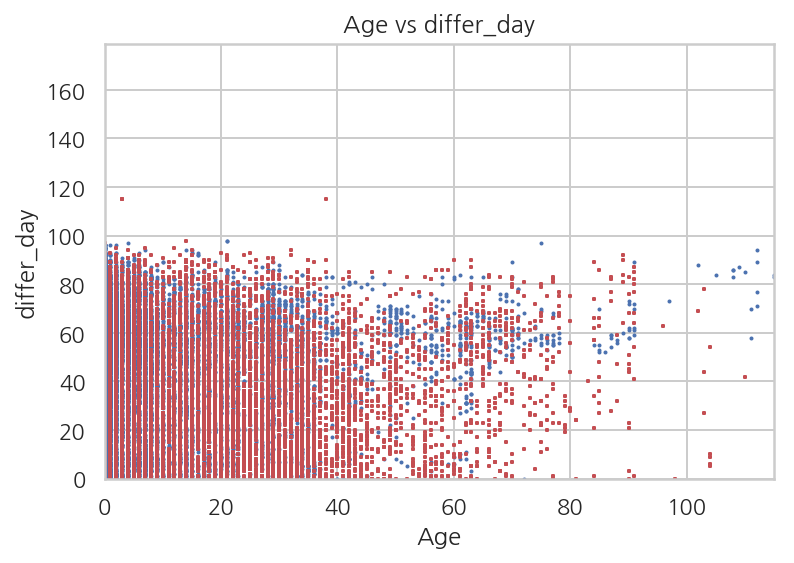

In [235]:
xmin=np.min(df.Age)
xmax=np.max(df.Age)
ymin=np.min(df.differ_day)
ymax=np.max(df.differ_day)

# XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
# ZZ = np.reshape(model_svc_ENN_all.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
# plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
plt.scatter(X_ENN_all_samp[:,:2][y_ENN_all_samp == "No", 0], X_ENN_all_samp[:,:2][y_ENN_all_samp == "No", 1], c='b', marker='o', label='클래스 1', s=1)
plt.scatter(X_ENN_all_samp[:,:2][y_ENN_all_samp == "Yes", 0], X_ENN_all_samp[:,:2][y_ENN_all_samp == "Yes", 1], c='r', marker='s', label='클래스 0', s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Age vs differ_day")
plt.ylabel("differ_day")
plt.xlabel("Age")


In [176]:
from sklearn.naive_bayes import *

In [237]:
X_ENN_all_samp1, y_ENN_all_samp1 = EditedNearestNeighbours(kind_sel="all", n_neighbors=10, random_state=0).fit_sample(X_ENN_all_samp, y_ENN_all_samp)

Text(0.5,0,'Age')

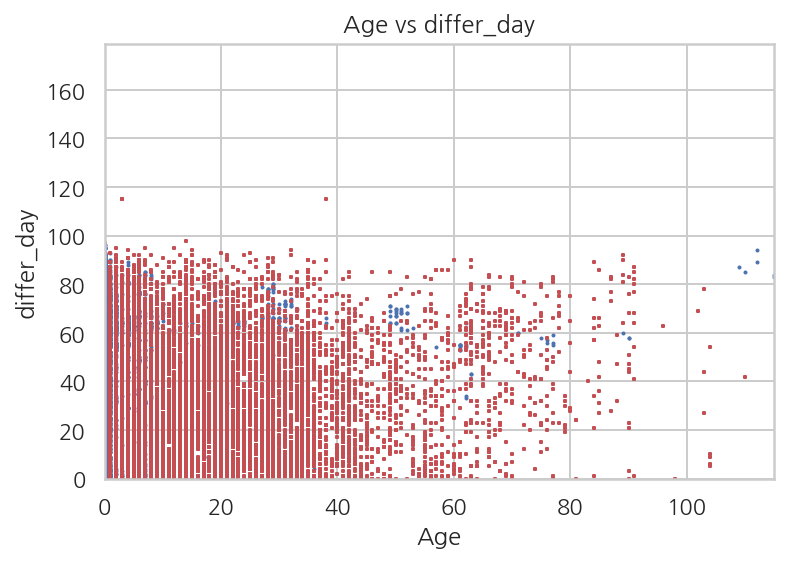

In [239]:
xmin=np.min(df.Age)
xmax=np.max(df.Age)
ymin=np.min(df.differ_day)
ymax=np.max(df.differ_day)

# XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
# ZZ = np.reshape(model_svc_ENN_all.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
# plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
plt.scatter(X_ENN_all_samp1[:,:2][y_ENN_all_samp1 == "No", 0], X_ENN_all_samp1[:,:2][y_ENN_all_samp1 == "No", 1], c='b', marker='o', label='클래스 1', s=1)
plt.scatter(X_ENN_all_samp1[:,:2][y_ENN_all_samp1 == "Yes", 0], X_ENN_all_samp1[:,:2][y_ENN_all_samp1 == "Yes", 1], c='r', marker='s', label='클래스 0', s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Age vs differ_day")
plt.ylabel("differ_day")
plt.xlabel("Age")


## Neighbourhood Cleaning Rule

In [147]:
X_NCR_samp, y_NCR_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5, random_state=0).fit_sample(X_train, y_train)

TypeError: bad operand type for unary ~: 'str'

## SMOTETomek

In [148]:
X_train.columns

Index(['differ_day', 'Age', 'temperature', 'latitude', 'longitude',
       'Diabetes_1', 'weather_Breezy and Overcast', 'weather_Clear',
       'weather_Drizzle', 'weather_Foggy', 'weather_Humid',
       'weather_Humid and Mostly Cloudy', 'weather_Humid and Partly Cloudy',
       'weather_Light Rain and Breezy', 'weather_Mostly Cloudy',
       'weather_Overcast', 'weather_Partly Cloudy',
       'weather_Windy and Overcast', 'Gender_M', 'SMS_received_1',
       'Hipertension_1', 'scheduled_Hour_11', 'scheduled_Hour_12',
       'scheduled_Hour_13', 'scheduled_Hour_14', 'scheduled_Hour_15',
       'scheduled_Hour_16', 'scheduled_Hour_17', 'scheduled_Hour_18',
       'scheduled_Hour_19', 'scheduled_Hour_20', 'scheduled_Hour_21',
       'scheduled_Hour_6', 'scheduled_Hour_7', 'scheduled_Hour_8',
       'scheduled_Hour_9', 'Handcap_1', 'Handcap_2', 'Handcap_3', 'Handcap_4',
       'Scholarship_1', 'scheduled_dayofweek_1', 'scheduled_dayofweek_2',
       'scheduled_dayofweek_3', 'scheduled_da

In [149]:
set(X_SMOTETomek_samp[:,5])

{0.0,
 1.0,
 0.43552799084502425,
 0.3973096655594226,
 0.9239441808184843,
 0.9426778963307356,
 0.856835866553812,
 0.18043309942533625,
 0.2509739423039896,
 0.6383655901327252,
 0.9424187818798373,
 0.8145118768424987,
 0.6161945954996605,
 0.017477006313679877,
 0.1885925428956272,
 0.9767974718682455,
 0.5941323090803154,
 0.949887436826263,
 0.5257272836736927,
 0.8190178267477147,
 0.4905313496514485,
 0.8161510983682523,
 0.24476151864864493,
 0.6299984761663358,
 0.019314933792682454,
 0.021409092474212188,
 0.7866306041079524,
 0.7929941910041485,
 0.5291479759947684,
 0.6521323545583656,
 0.09737216003485549,
 0.9001790420395438,
 0.6506558843772056,
 0.31676845255239616,
 0.11292035827349967,
 0.1518655543101889,
 0.2577397998322166,
 0.7613461679889374,
 0.1426490804894106,
 0.6370650220964412,
 0.5969120536142483,
 0.8269278158186508,
 0.7068186598562689,
 0.7276549481016424,
 0.9241676146729084,
 0.7610799790654336,
 0.05396736569556093,
 0.8657049808135379,
 0.74393547

In [143]:
X_SMOTETomek_samp, y_SMOTETomek_samp = SMOTETomek(random_state=4).fit_sample(X_train, y_train)

In [144]:
len(X_train)

77364

In [145]:
len(X_SMOTETomek_samp)

122172

Text(0.5,0,'Age')

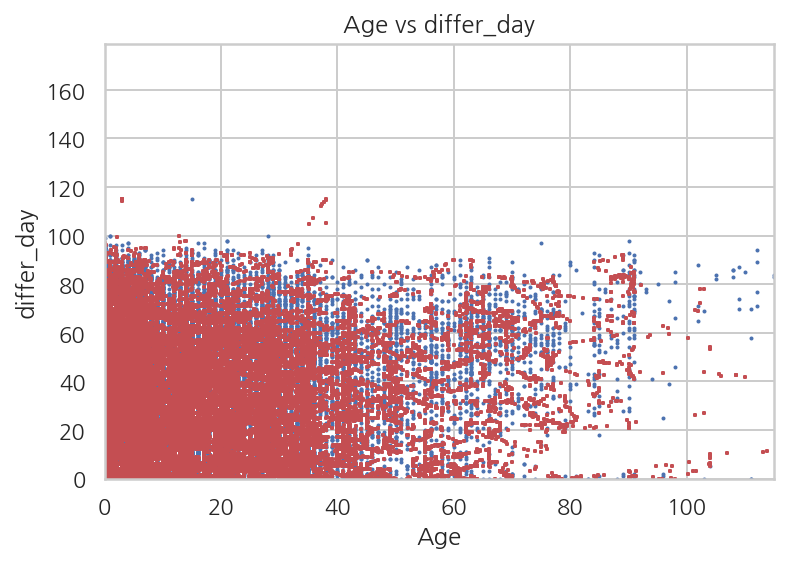

In [146]:
xmin=np.min(df.Age)
xmax=np.max(df.Age)
ymin=np.min(df.differ_day)
ymax=np.max(df.differ_day)

# XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
# ZZ = np.reshape(model_svc_ENN_all.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
# plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
plt.scatter(X_SMOTETomek_samp[:,:2][y_SMOTETomek_samp == "No", 0], X_SMOTETomek_samp[:,:2][y_SMOTETomek_samp == "No", 1], c='b', marker='o', label='클래스 1', s=1)
plt.scatter(X_SMOTETomek_samp[:,:2][y_SMOTETomek_samp == "Yes", 0], X_SMOTETomek_samp[:,:2][y_SMOTETomek_samp == "Yes", 1], c='r', marker='s', label='클래스 0', s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Age vs differ_day")
plt.ylabel("differ_day")
plt.xlabel("Age")

In [ ]:
%%time
model_svc_SMOTETomek = SVC().fit(X_SMOTETomek_samp, y_SMOTETomek_samp)

In [146]:
%%time
y_pred_train6 = model_svc_SMOTETomek.predict(X_train)
y_pred_test6 = model_svc_SMOTETomek.predict(X_test)

CPU times: user 2min 8s, sys: 933 ms, total: 2min 9s
Wall time: 2min 10s


In [152]:
confusion_matrix(y_test, y_pred_test0, labels=["Yes", "No"])

array([[ 5241,  1490],
       [11785, 14640]])

In [153]:
print(classification_report(y_train, y_pred_train0))

              precision    recall  f1-score   support

          No       0.92      0.57      0.70     61781
         Yes       0.32      0.80      0.46     15583

   micro avg       0.61      0.61      0.61     77364
   macro avg       0.62      0.68      0.58     77364
weighted avg       0.80      0.61      0.65     77364



In [154]:
print(classification_report(y_test, y_pred_test0))

              precision    recall  f1-score   support

          No       0.91      0.55      0.69     26425
         Yes       0.31      0.78      0.44      6731

   micro avg       0.60      0.60      0.60     33156
   macro avg       0.61      0.67      0.56     33156
weighted avg       0.79      0.60      0.64     33156



In [155]:
accuracy_score(y_test, y_pred_test0)

0.5996199782844734

## 나이브 베이즈 분류 모형

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('classifier1',),
    ('classifier2',TfidfTransformer()),
    ('classifier3',MultinomialNB()),
])
model_norm = GaussianNB().fit(X, y)